### Rolling cadence 

Whether or not, and how, to add rolling cadence is an important question. 

Let's look at some of the science impacts.

The new v2.0 baseline, `baseline_v2.0_10yrs` and its successor `baseline_v2.1_10yrs` include a 2-band rolling cadence at 90% strength in the low-dust WFD region. "2-band" means 1/2 sky active during the rolling periods -- the actual "active" 1/2 of the sky consists of 2 regions, north and south, to distribute follow-up requirements over both northern and southern hemispheres. 

In [2]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf

In [45]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values
summary_source = 'summary_2022_08_01.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metrics_source = 'metric_sets.json'
metric_set = maf.get_metric_sets(metrics_source)

Let's just visualize what the rolling cadence means, briefly, by mapping the visits occuring during 1 year

In [46]:
fam = ['rolling']
baseline_run = families.loc['rolling', 'reference']
these_runs = np.concatenate([[baseline_run], families.explode('run').loc[fam, 'run']])
lines = np.array([1, 2, 6, 9, 10, 11, 13])

In [47]:
maf.describe_families(families.loc[['rolling'], :],
                        summary=summaries,
                        table_metric_set=metric_set.loc["short description"],
                        plot_metric_set=None,
                        baseline_run=families.loc['rolling', "reference"],)

---
**rolling** : The rolling family covers a wide variety of rolling cadence variations. These are arranged in general estimation of the impact of the rolling cadence, from "least" to "most" - no_roll has no rolling cadence at all, then variations on the number of stripes (ns=2/3/6) are added, as as which areas of the sky (WFD only, adding the bulge WFD-area, all-sky). The strength of rolling is also varied (rw=50,80 or 90%).  
**version**: 2.0  
**runs**:  


(None, None)

In [6]:
#add count metrics run in one year 
ddir = '/Users/lynnej/opsim/v2.0'
nvisits = {}
gaps = {}
summarystats = [maf.MedianMetric(), maf.MeanMetric(), 
                maf.PercentileMetric(percentile=30), maf.PercentileMetric(percentile=80)]
for r in these_runs:
    print(f'running {r}')
    constraint='night > 365*3.5 and night < 365*4.5 and note not like "%DD%"'
    slicer = maf.HealpixSlicer(nside=64, verbose=False)
    m1 = maf.CountMetric(col='observationStartMJD', metricName='Nvisits', units='')
    nvisits[r] = maf.MetricBundle(metric=m1,
                                 slicer=slicer,
                                 constraint=constraint,
                                 info_label='year3.5', 
                                  summaryMetrics=summarystats, 
                                  runName=r)
    # Running this over ONE year
    m2 = maf.InterNightGapsMetric(metricName="Median Inter-Night Gap", 
                                      mjdCol='observationStartMJD', reduceFunc=np.median)
    gaps[r] = maf.MetricBundle(metric=m2,
                                 slicer=slicer,
                                 constraint=constraint,
                                 info_label='year3.5', 
                                  summaryMetrics=summarystats, 
                                  runName=r)
    bdict = {'nvis': nvisits[r], 'gaps': gaps[r]}
    g = maf.MetricBundleGroup(bdict, os.path.join(ddir, r + ".db"), outDir='temp', verbose=False)
    g.runAll()

running baseline_v2.0_10yrs
running noroll_v2.0_10yrs
running rolling_ns2_rw0.5_v2.0_10yrs
running rolling_ns3_rw0.5_v2.0_10yrs
running rolling_ns2_rw0.9_v2.0_10yrs
running rolling_ns3_rw0.9_v2.0_10yrs
running rolling_bulge_ns2_rw0.5_v2.0_10yrs
running rolling_bulge_ns2_rw0.8_v2.0_10yrs
running rolling_bulge_ns2_rw0.9_v2.0_10yrs
running rolling_all_sky_ns2_rw0.9_v2.0_10yrs
running roll_early_v2.0_10yrs
running six_rolling_ns6_rw0.5_v2.0_10yrs
running six_rolling_ns6_rw0.9_v2.0_10yrs
running rolling_bulge_6_v2.0_10yrs


Median       Mean  30th%ile  80th%ile
baseline_v2.0_10yrs                     55.0  68.130478      26.0     124.0
noroll_v2.0_10yrs                       82.0  67.930738      45.0      92.0
rolling_ns2_rw0.5_v2.0_10yrs            63.0  68.167741      38.0     108.0
rolling_ns3_rw0.5_v2.0_10yrs            53.0  68.020968      36.0     107.0
rolling_ns2_rw0.9_v2.0_10yrs            55.0  68.130478      26.0     124.0
rolling_ns3_rw0.9_v2.0_10yrs            34.0  68.443933      26.0     119.0
rolling_bulge_ns2_rw0.5_v2.0_10yrs      63.0  68.113236      37.0     111.0
rolling_bulge_ns2_rw0.8_v2.0_10yrs      53.0  68.260510      28.0     124.0
rolling_bulge_ns2_rw0.9_v2.0_10yrs      52.0  68.290186      27.0     126.0
rolling_all_sky_ns2_rw0.9_v2.0_10yrs    52.0  68.331961      27.0     124.0
roll_early_v2.0_10yrs                   47.0  68.106566      31.0     118.0
six_rolling_ns6_rw0.5_v2.0_10yrs        43.0  68.246516      30.0      86.0
six_rolling_ns6_rw0.9_v2.0_10yrs        17.0  69.483883      11.0      95.0
rolling_bulge_6_v2.0_10yrs              47.0  68.131537      26.0     123.0

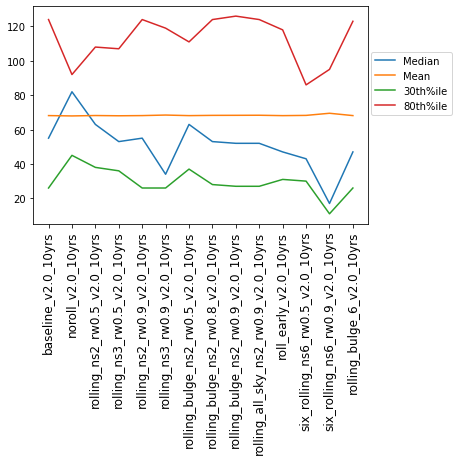

In [7]:
# 30th/50th/80th percentile values of the number of visits over the sky for this year
d = pd.DataFrame([nvisits[r].summaryValues for r in these_runs], index=these_runs)
ax = d.plot()
xi = np.arange(len(these_runs))
plt.xticks(xi, these_runs, rotation=90, fontsize='large')
plt.legend(loc=(1.01, 0.5))
d

30         80
baseline_v2.0_10yrs                   2.852249   8.992965
noroll_v2.0_10yrs                     3.524060   7.007118
rolling_ns2_rw0.5_v2.0_10yrs          3.004434   7.490716
rolling_ns3_rw0.5_v2.0_10yrs          3.593932   7.887062
rolling_ns2_rw0.9_v2.0_10yrs          2.852249   8.992965
rolling_ns3_rw0.9_v2.0_10yrs          2.979054   9.022131
rolling_bulge_ns2_rw0.5_v2.0_10yrs    2.991995   7.503380
rolling_bulge_ns2_rw0.8_v2.0_10yrs    2.854113   8.938459
rolling_bulge_ns2_rw0.9_v2.0_10yrs    2.791989   8.903076
rolling_all_sky_ns2_rw0.9_v2.0_10yrs  2.505317   8.979080
roll_early_v2.0_10yrs                 2.934707   8.439458
six_rolling_ns6_rw0.5_v2.0_10yrs      3.997854   8.157324
six_rolling_ns6_rw0.9_v2.0_10yrs      3.408545  16.075069
rolling_bulge_6_v2.0_10yrs            2.450848   8.405790

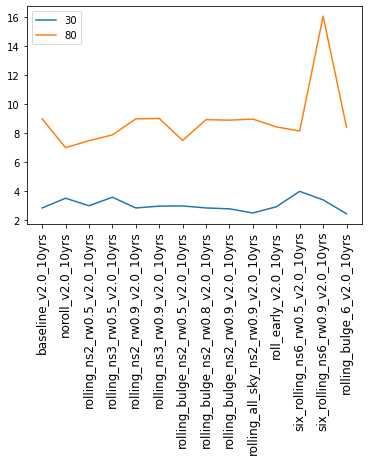

In [8]:
# 20th/50th/80th percentile values of the gaps between visits over the sky for this year
# I suspect that this (and the plot above) indicate that 20th/80th percentile can fall in/out of rolling regions
d = pd.DataFrame([(gaps[r].summaryValues['30th%ile'], gaps[r].summaryValues['80th%ile']) 
                  for r in these_runs], columns =['30', '80',],
                 index=these_runs)
ax = d.plot()
xi = np.arange(len(these_runs))
plt.xticks(xi, these_runs, rotation=90, fontsize='large')
d

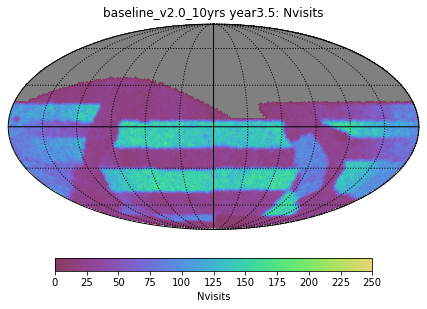

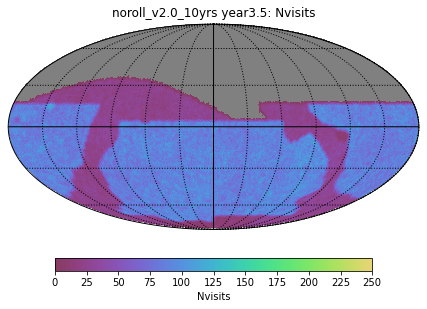

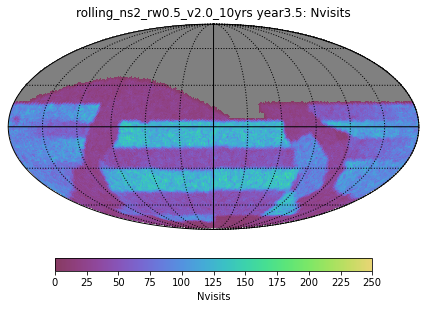

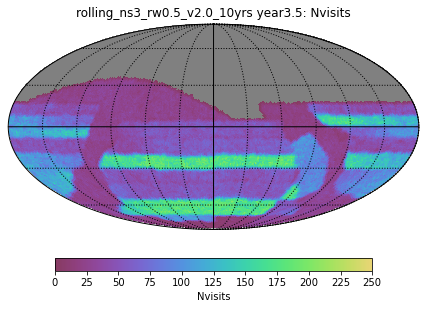

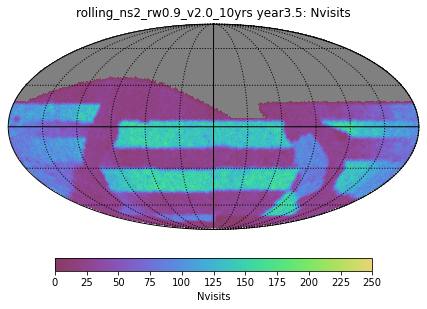

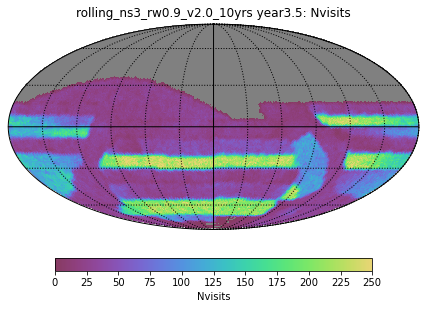

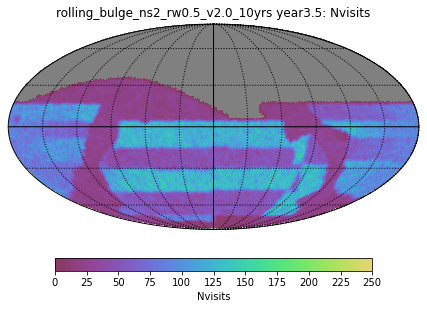

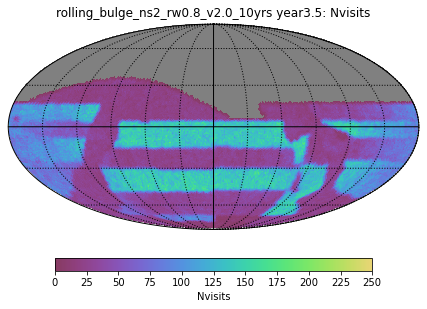

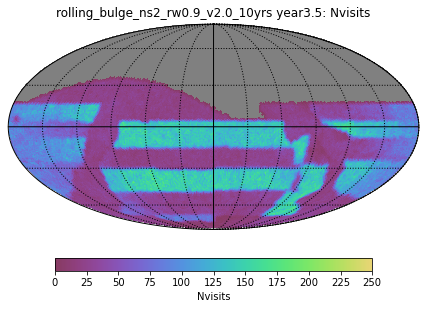

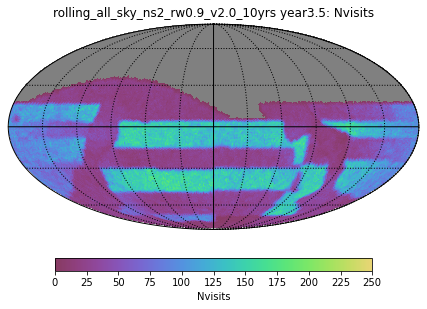

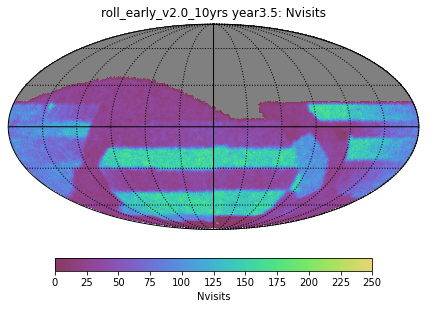

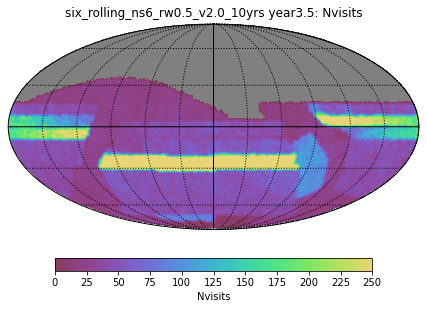

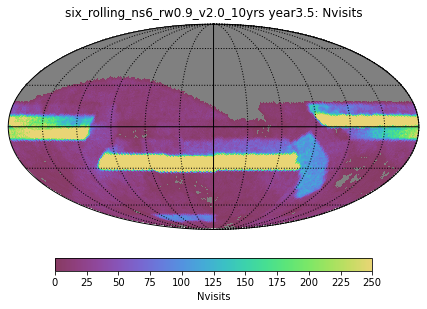

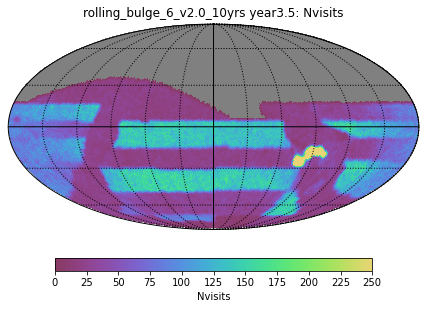

In [9]:
ph = maf.PlotHandler(outDir='temp', thumbnail=False, figformat='png')
for r in these_runs:
    ph.setMetricBundles([nvisits[r]])
    with warnings.catch_warnings():
        ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'colorMin':0, 'colorMax': 250})

In [48]:
# list the metric sets
msets = list(metric_set.groupby('metric set').first().index)
msets = [m for m in msets if 'DDF' not in m]

for k in msets:
    print(k, len(metric_set.loc[k]))
    # Check that the metrics are correctly named and in the summary file
    summaries.loc[:, metric_set.loc[k]['metric']]

AGN N QSO 6
AGN SF 12
AGN short 5
AGN timelag 12
DESC WFD 10
GP filters 12
GP footprint 6
GP season 6
GP visit 6
N Visits 9
SCOC 22
SL TDC 6
SRD 5
SSO N Objs 6
SSO discovery 14
SSO discovery options 22
SSO fraction 3 bands 14
SSO fraction 4 bands 14
SSO fraction 5 bands 14
SSO fraction 6 bands 14
SSO lightcurve inversion 8
Stars 9
TVS KNe 7
TVS KNe short 3
TVS PeriodModulation 8
TVS PeriodicDetect 6
TVS Presto 2
TVS TDE 5
TVS Tgaps 12
TVS XRB 3
TVS anomalies 5
TVS microlensing all 17
TVS microlensing short 4
TVS short 6
WFD Depths 18
cadence 8
galaxies 3
plot areas 5
radar 11
short description 10


First we'd like to just check if rolling cadence impacts the number of visits per pointing or the depths. 

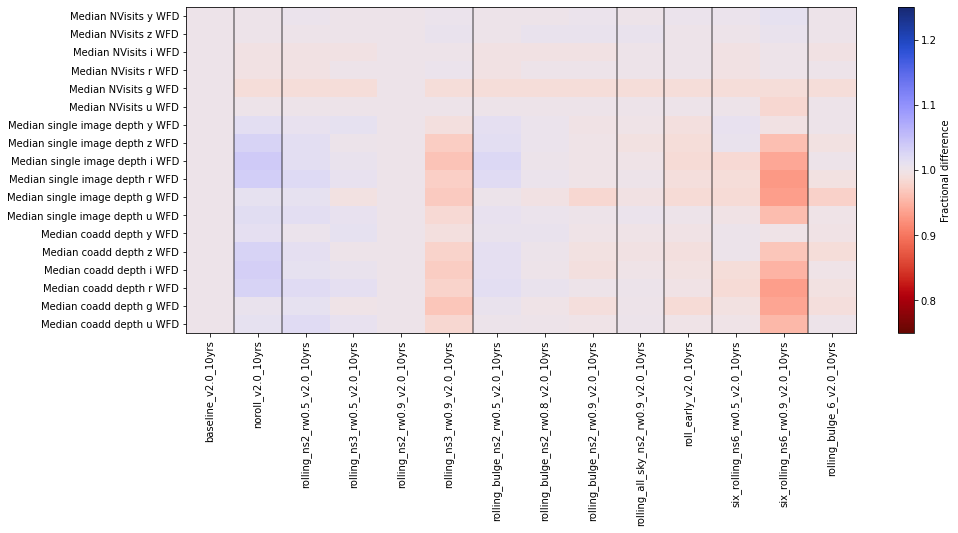

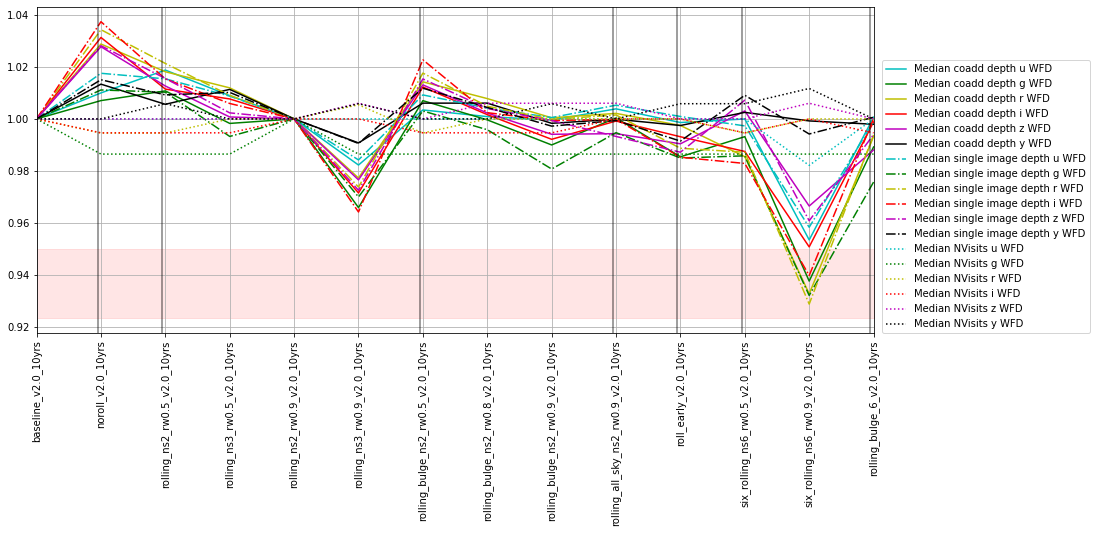

In [49]:
k = 'WFD Depths'

# Plot two versions of the figures
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_set.loc[k]['short_name'],
                                   metric_set=metric_set.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                              baseline_run=baseline_run,
                              metric_set=metric_set.loc[k],
                              metric_label_map=metric_set.loc[k]['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

We see very little difference in the number of visits per pointing, although there are some slight changes to the single image median depths (and from there to the coadded depths). This is likely because rolling constricts to various extents where/when we can observe particular parts of the sky, so the final choice of bandpass or location on-sky may be slightly less than optimal without constraints. An example might be needing to observe closer to the moon due to declination constraints than otherwise we may have chosen to do. However, this is a smaller than 5% effect - until 6 band rolling cadence is implemented, and even then it's only about a 7% effect at most - so is a minor impact. 

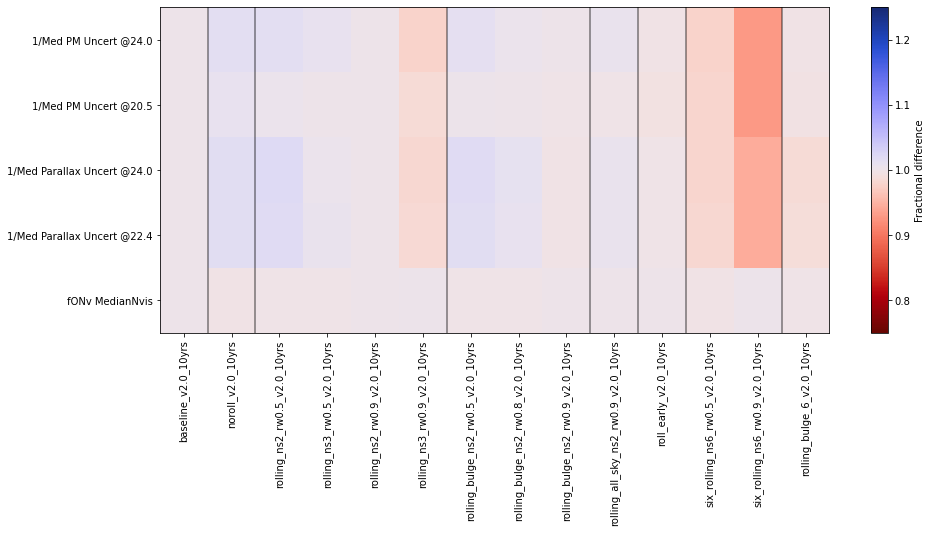

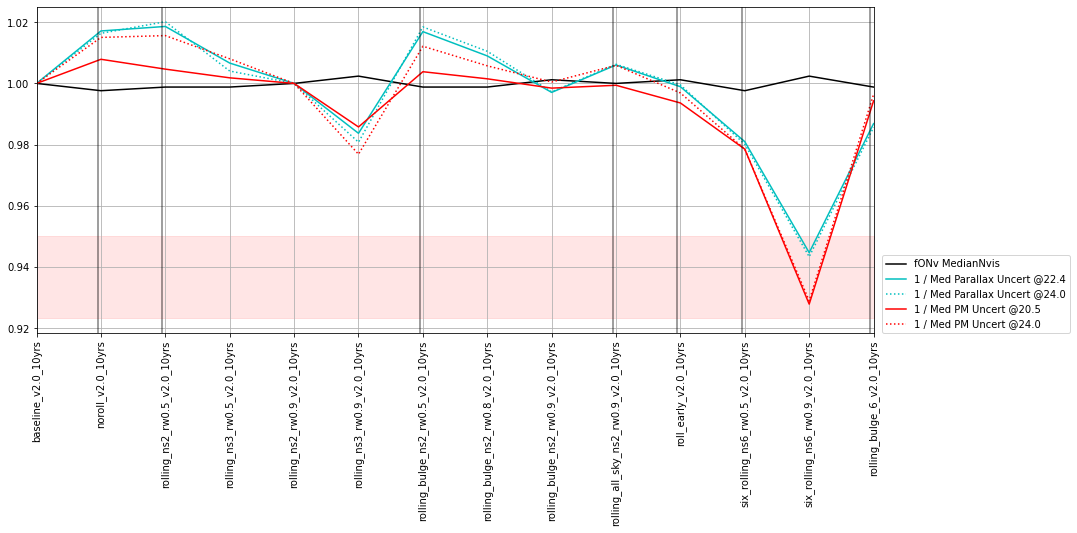

In [50]:
## SRD metrics 

k = 'SRD'

# Plot two versions of the figures
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_set.loc[k]['short_name'],
                                   metric_set=metric_set.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                              baseline_run=baseline_run,
                              metric_set=metric_set.loc[k],
                              metric_label_map=metric_set.loc[k]['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

SRD metrics related to astrometry fare slightly better (but only by about 2%) with less strong or no rolling cadence. Astrometry metrics are related to long cadence effects, so this is reasonable. 
No significant negative impacts, until a strong 6-band rolling cadence is added. 
The median number of visits per pointing stays consistent across simulations, as expected.

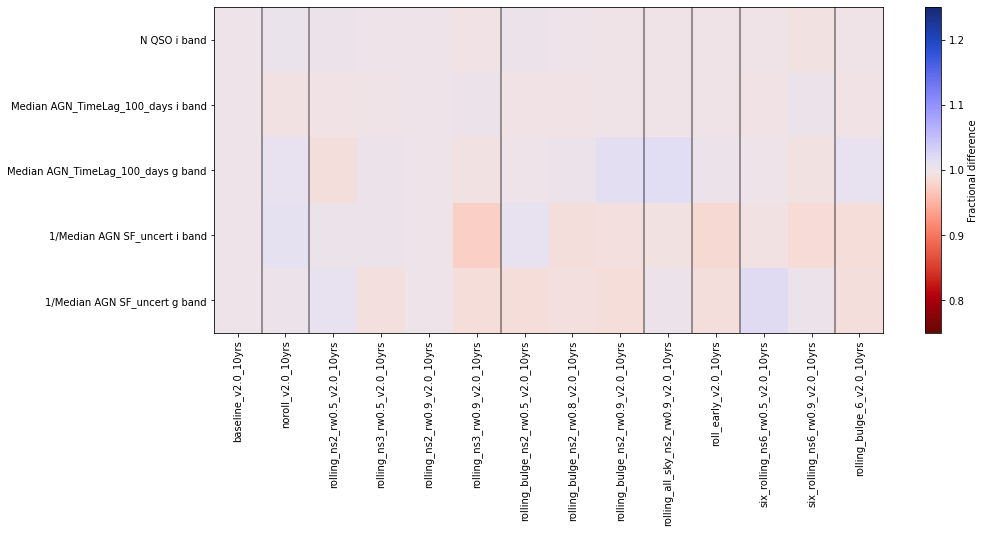

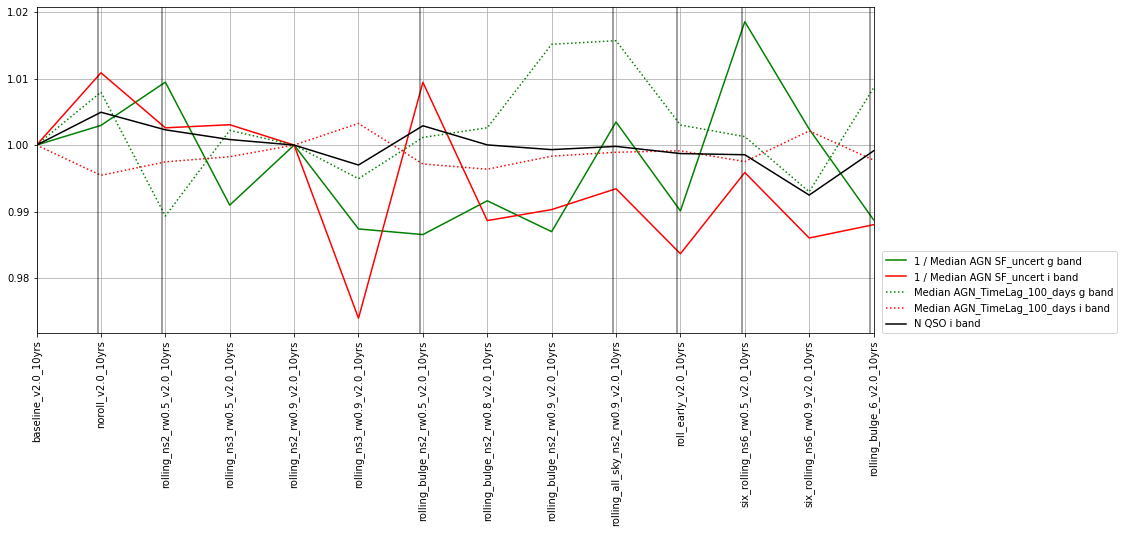

In [51]:
# AGN metrics
k_sets = ['AGN short']

msub = metric_set.loc[k_sets].reset_index('metric set')
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

for k in k_sets:
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value',
                                 shade_fraction=0)
    ylims = ax.get_ylim()
    ax.set_ylim(max(0.2, ylims[0]), min(2, ylims[1]))
    fig.set_figwidth(15)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

The metrics for AGN include a count of the number of QSO (NQSO), and two cadence-dependent measurements. The AGN SF Uncertainty attempts to estimate the uncertainty on any measured Structure Function by looking at the distribution of observations over a logarithmic set of time bins; the timeLags metric evaluates how many intervals of 100 or 5 days (the 'time lag') are Nyquist sampled.

The number of QSO does not change appreciably with rolling cadence; this is expected, as the total coadded depths don't change much. The SF Uncertainty does vary across different versions of the rolling cadence, but primary in the median value -- the area which meets a particular uncertainty threshold (0.25) holds fairly constant. The uncertainty scatters both positive and negative directions, and often depends on which bandpass is being considered. Likely this indicates a fair bit of noise in the metric (that it is quite sensitive to exact timing of observations in a given bandpass). The median timelag values also scatter strongly for the shortest timescales (5 days), although the 100 day sampling is fairly constant across all rolling cadence variations. Without further guidance, it is hard to make any determination on whether rolling cadence is preferable or not, given the scatter.

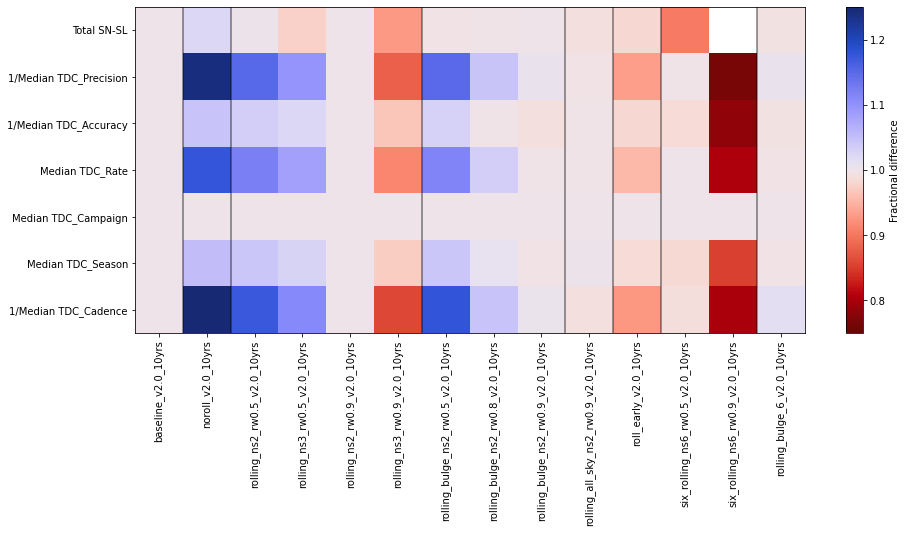

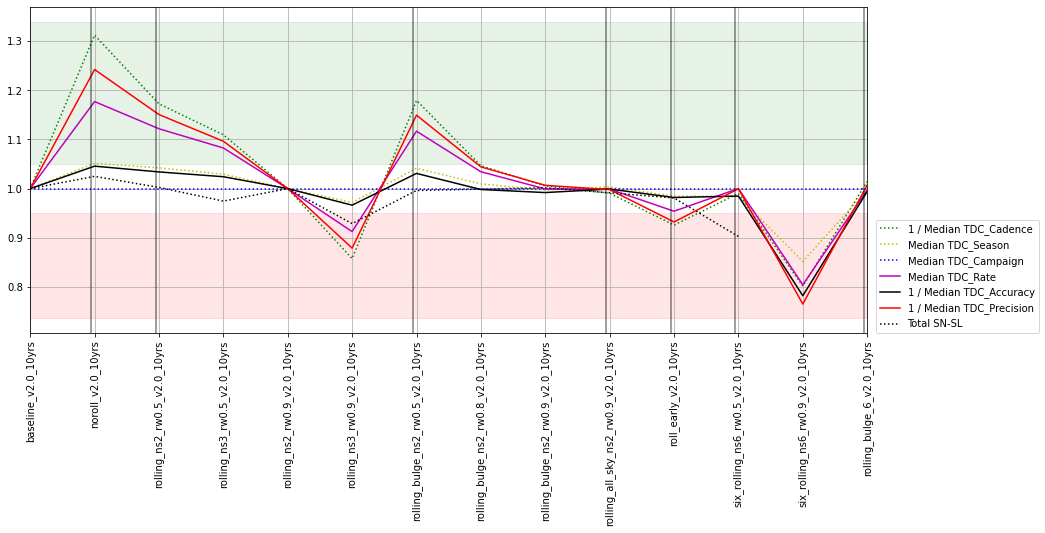

In [52]:
# StrongLensing metrics

k_sets = [k for k in msets if k.startswith('SL')]

msub = metric_set.loc[k_sets].reset_index('metric set')
# Add the strong lensed supernova metric
msub = pd.concat([msub, metric_set.loc['DESC WFD'].query('metric.str.contains("SNSL")')])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)


fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                              baseline_run=baseline_run,
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

These metrics, together, argue against rolling cadence. As rolling cadence gets stronger, the metric results get more negative. This is partly due to how the metrics themselves are written; the metrics include medians and means in season length and inter-night gaps across all years, which tend to bias towards the low-cadence parts of the sky / parts of the survey. Updates of the metrics themselves are planned, which may improve the expected results with rolling cadence, however this is still not an obvious conclusion.

Behind the metric code itself, the authors and science collaboration members believe these conclusions (against rolling cadence, and that the results are worse as rolling becomes stronger) hold true because the events they are looking for are fairly long-lived AND rare. A faster cadence in active rolling years is of little benefit, while the non-active years potentially fall below threshold or just fail to observe the phenomena (in the case of strongly lensed SN) due to having fewer visits. The smaller area of the sky which is observed at even a slightly higher cadence impacts the discovery rate, resulting in poorer science results. 

The addition of rolling cadence impacts the rate of observing time dleays by about 18%, and decreases the likelihood of detecting a strongly lensed SN by a few %. Adding a very strong (six-band level) rolling cadence decreases the likelihood of detecting SNSL to practically 0, and reduces the rate of time delay detection by about 20%. Between these levels, 2 or 3 band rolling at 50% strength is not significant for SNSL, but reduces the rate of time delay detection by about 10%, and moving to a 3-band rolling cadence at 90% strength decreases the number of SNSL detected by just over 5%. 

SSO discovery
SSO lightcurve inversion


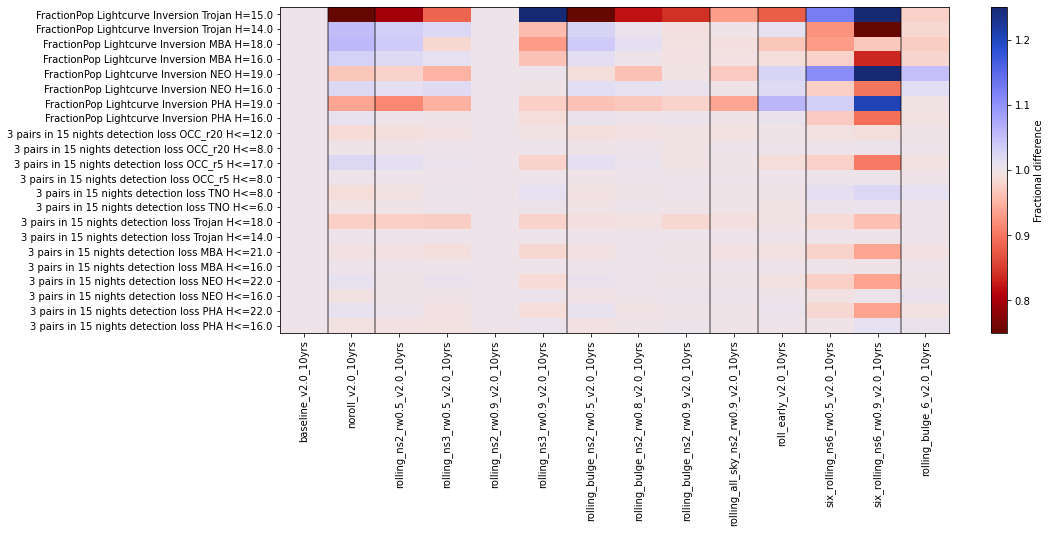

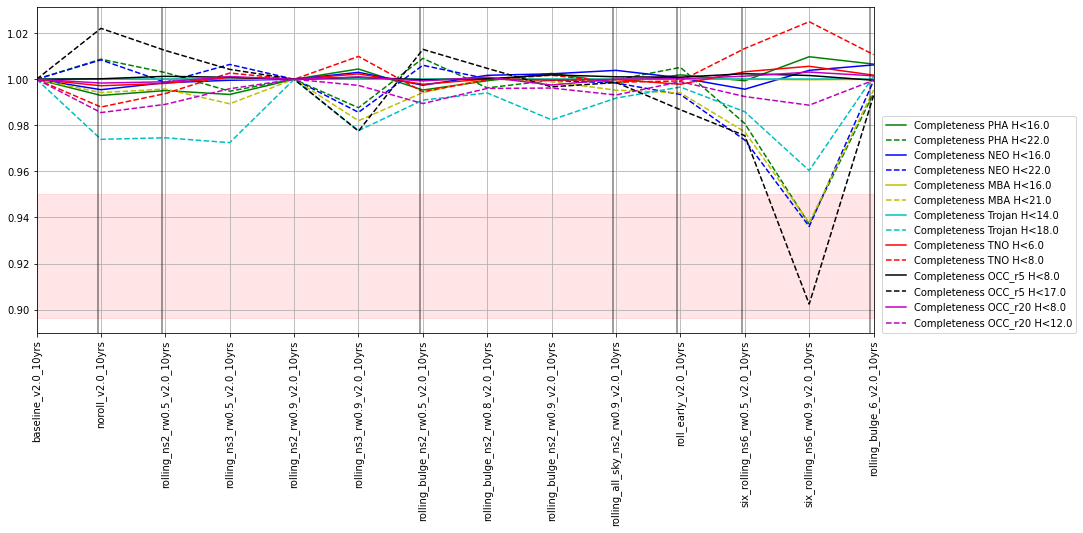

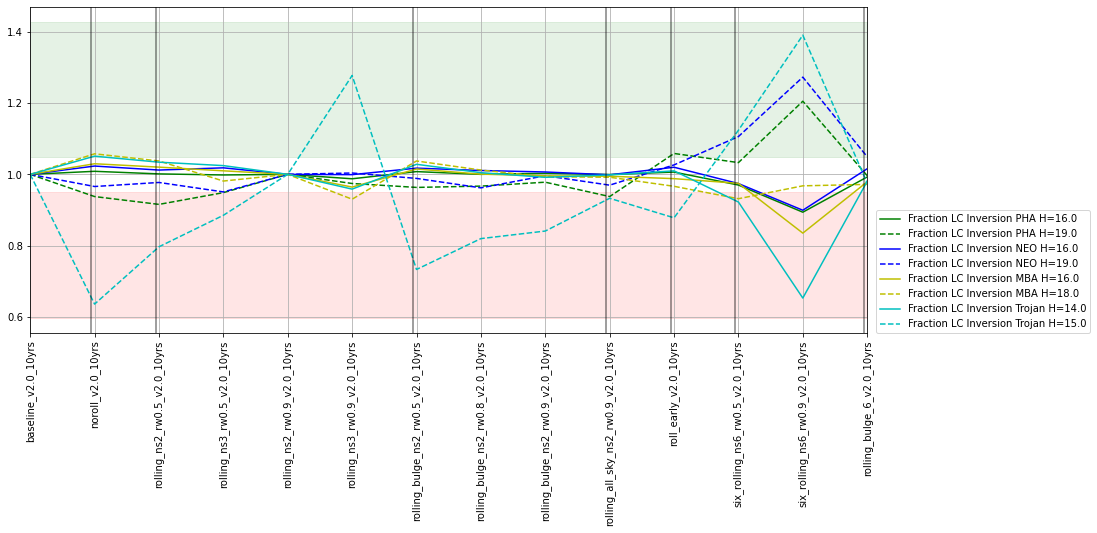

In [53]:
# sso metrics
k_sets = ['SSO discovery', 'SSO lightcurve inversion']

msub = metric_set.loc[k_sets].reset_index('metric set')
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

for k in k_sets:
    print(k)
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    #ax.set_ylim(0.5, 1.5)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)


The solar system metrics are extensive, but a summary set is represented here for completeness. The highest priority metrics include the discovery completeness and lightcurve inversion metrics; within these metrics, the results for Jovian Trojans are downweighted (as they tend to be more volatile than other populations). 

The addition of rolling cadence has some slight negative impact for NEO populations, but not others; in general rolling cadence has small but mixed impacts across populations up until strong six-band rolling cadence. With a six-band rolling cadence at 90% strength, Oort cloud comet completeness for faint objects falls by almost 10% and the total number of NEOs discovered falls by over 10% (when the smallest objects, down to H=25, are included). 
In general, color determination is only minorly impacted up until the strong six-band rolling cadence (at which point it can fall by 20% or so for most populations; the fraction of the population which acquired a full set of six-band colors can increase, but this is overall a small portion of the population and not the highest priority. A similar result is seen for the fraction of objects which receive enough observations for lightcurve inversion. 
The populations which show increases in metric values at six-band rolling make sense; these are populations in which each object is likely only visible for a limited amount of time before becoming too faint again -- a six-band rolling cadence packs more visits into the time when a particular object would be visible (at the expense of completely missing any observations of other objects). 

In general, solar system metrics indicate a fairly neutral response over rolling cadence variations, but reject a strong six-band rolling cadence as metrics fall by about 10% or so. In general, there will always be a trade-off point in each population where a trade-off between visits covering a longer time period (spreading observations across more objects) and visits covering a shorter time period more intensely (thus concentrating visits on a subset of objects in the population) occurs; the trade-off point will depend on the orbits of the objects in each population (and how long they are visible for) and the number of observations required for a given metric. It seems clear that most populations/objects meet this trade-off point quickly for a strong six-band rolling cadence, and the trade-off point doesn't hit most of these thresholds for the remainder populations, but the metrics themselves do not fully explore all solar system populations (no inter-stellar objects, for examples) and are not summarized at every H/size value. 

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/runComparison/summary_plots.py:326: UserWarning: There are infinite values in the plot of Median TgapsPercent_2-14hrs u band.
  warnings.warn(f"There are infinite values in the plot of {idx}.")
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/runComparison/summary_plots.py:326: UserWarning: There are infinite values in the plot of Median TgapsPercent_2-14hrs g band.
  warnings.warn(f"There are infinite values in the plot of {idx}.")


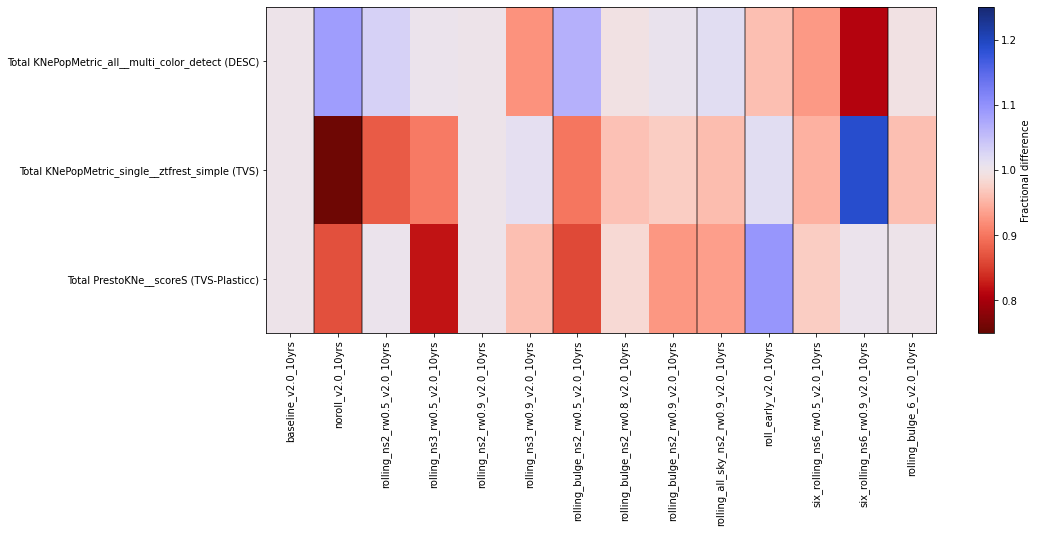

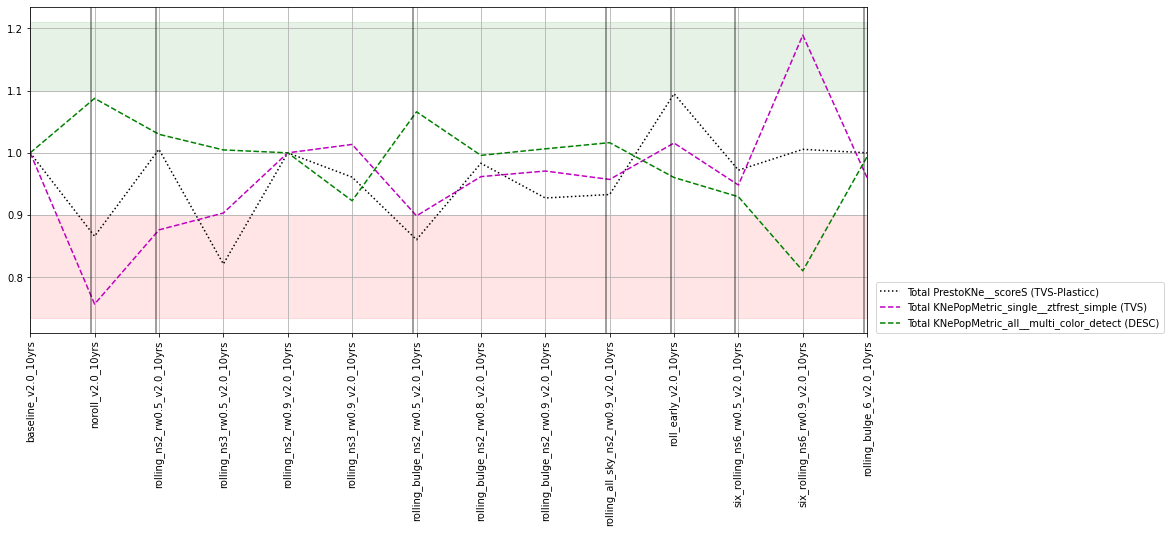

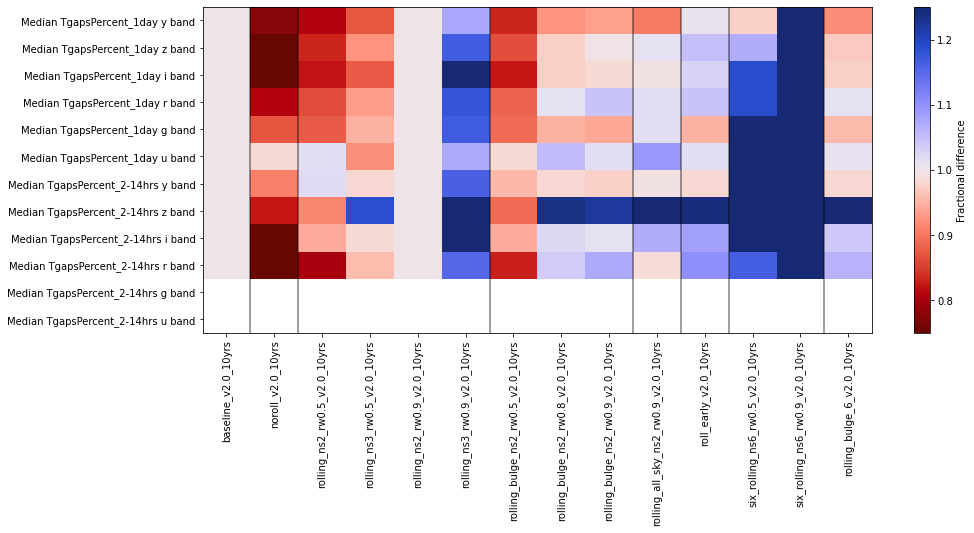

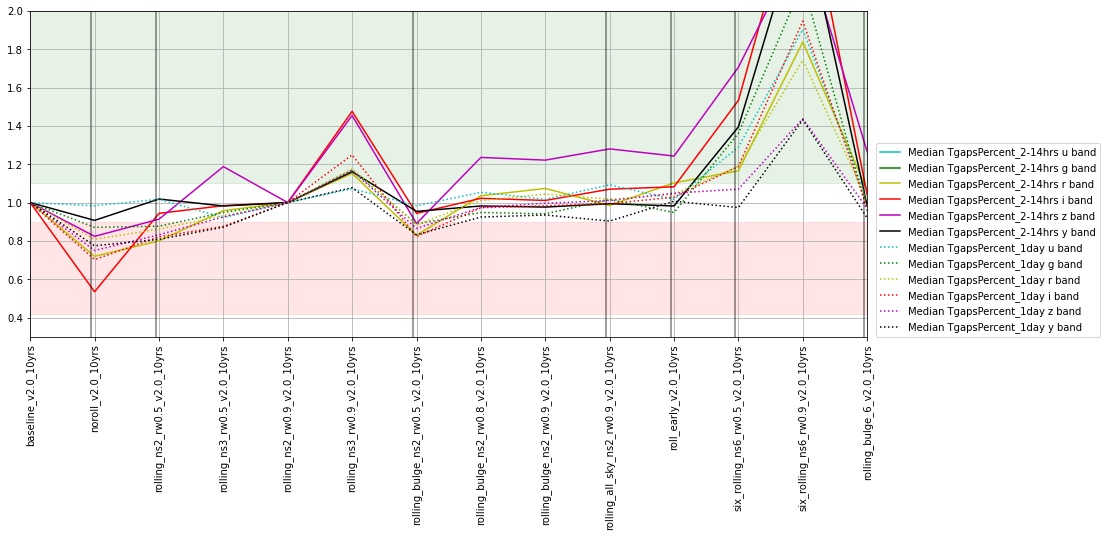

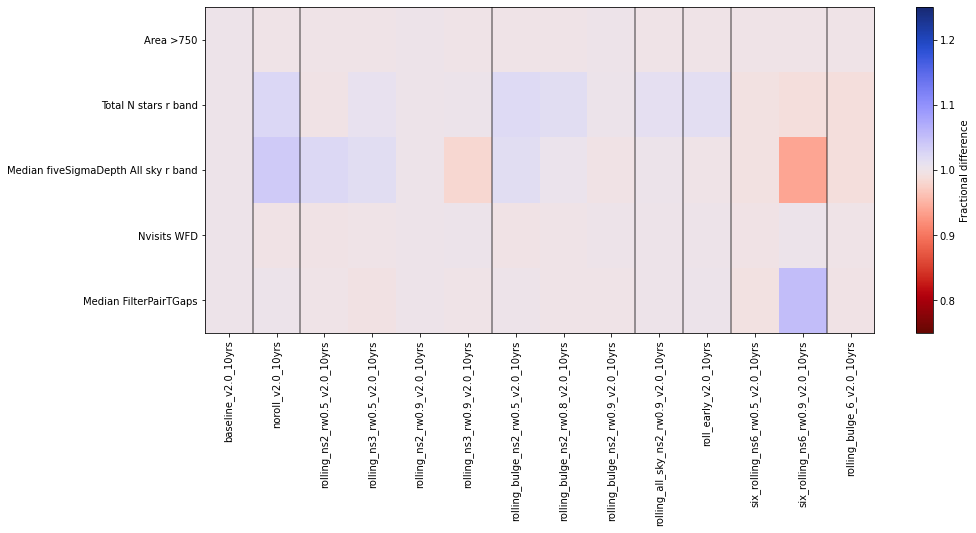

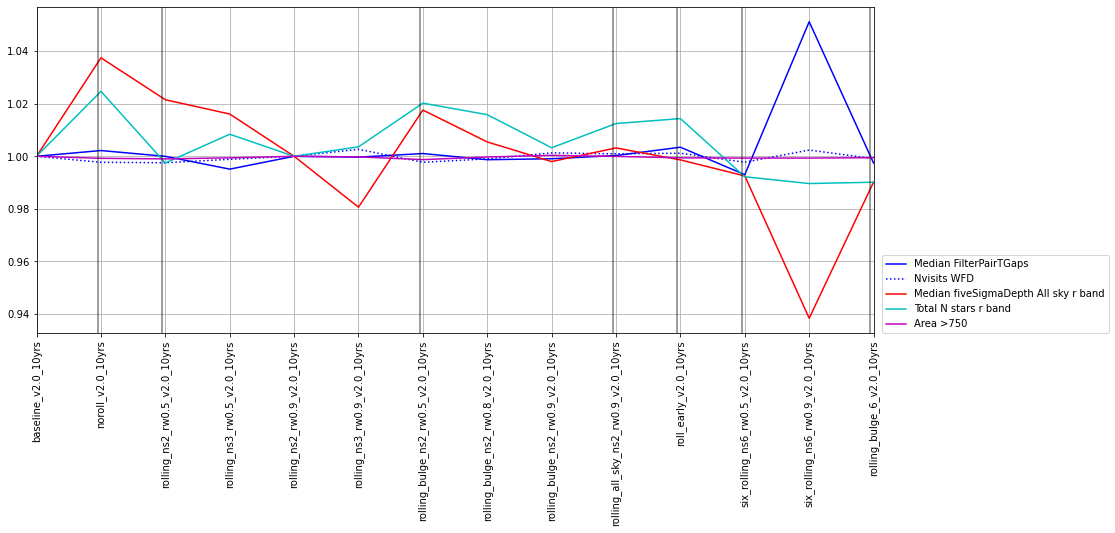

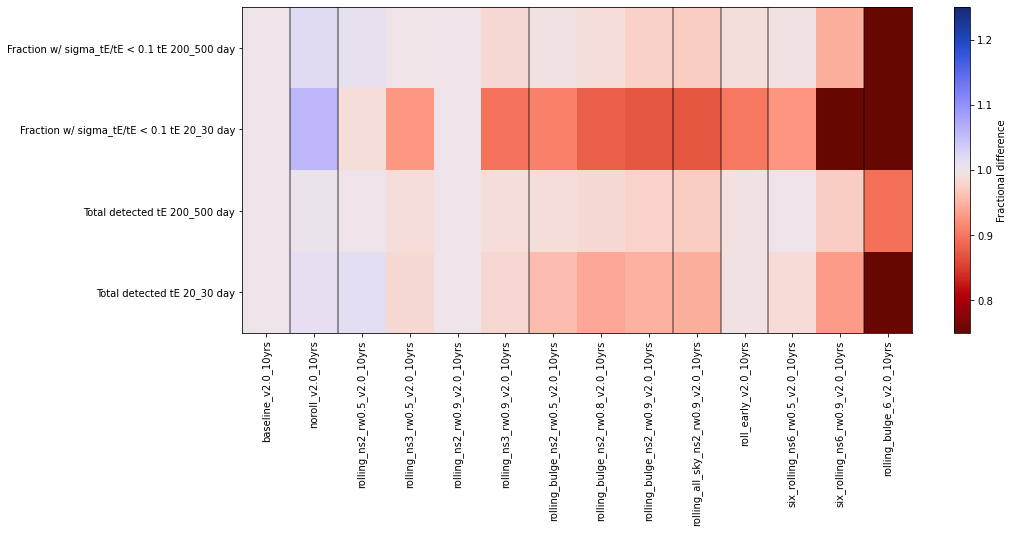

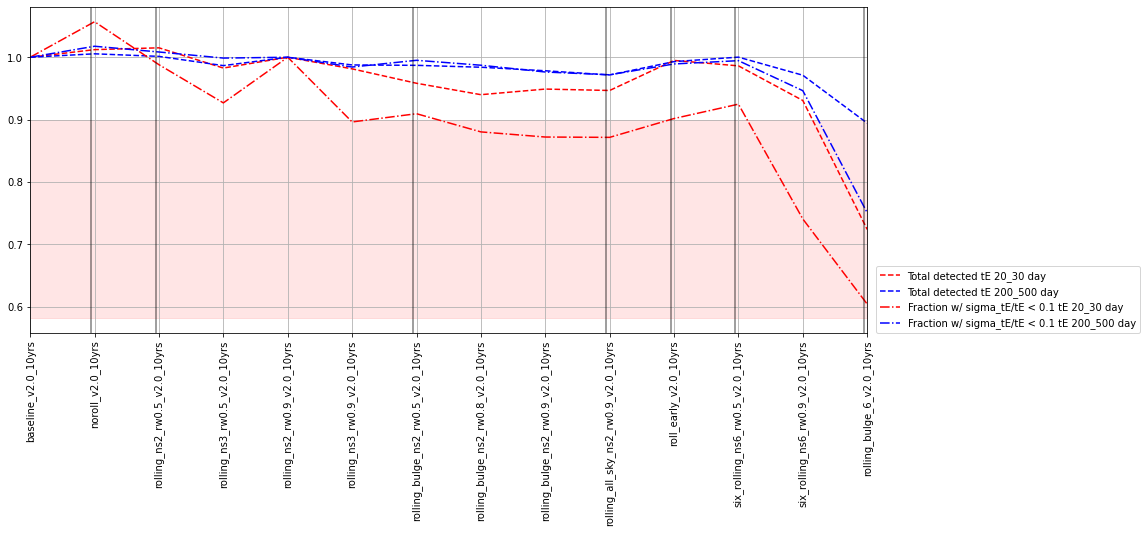

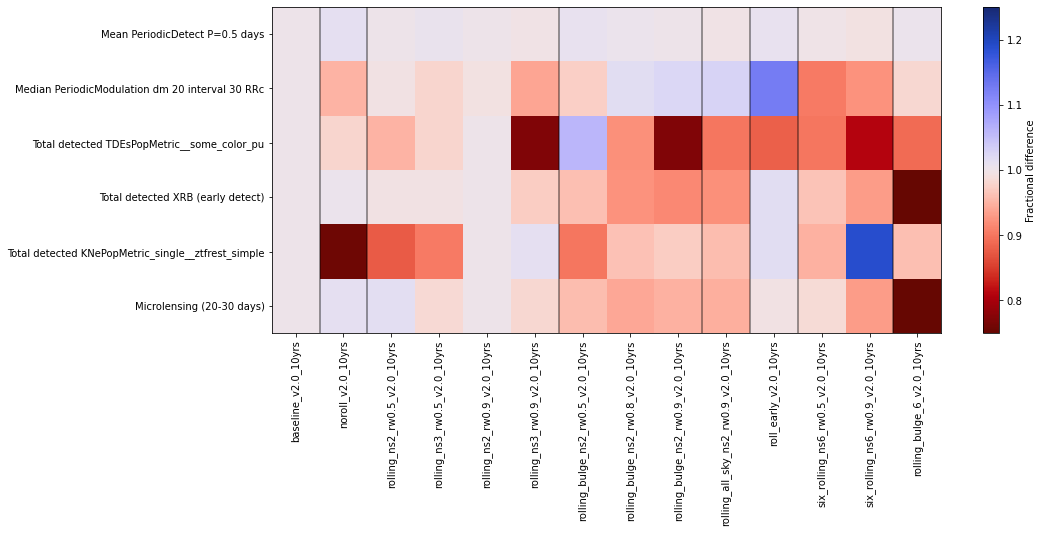

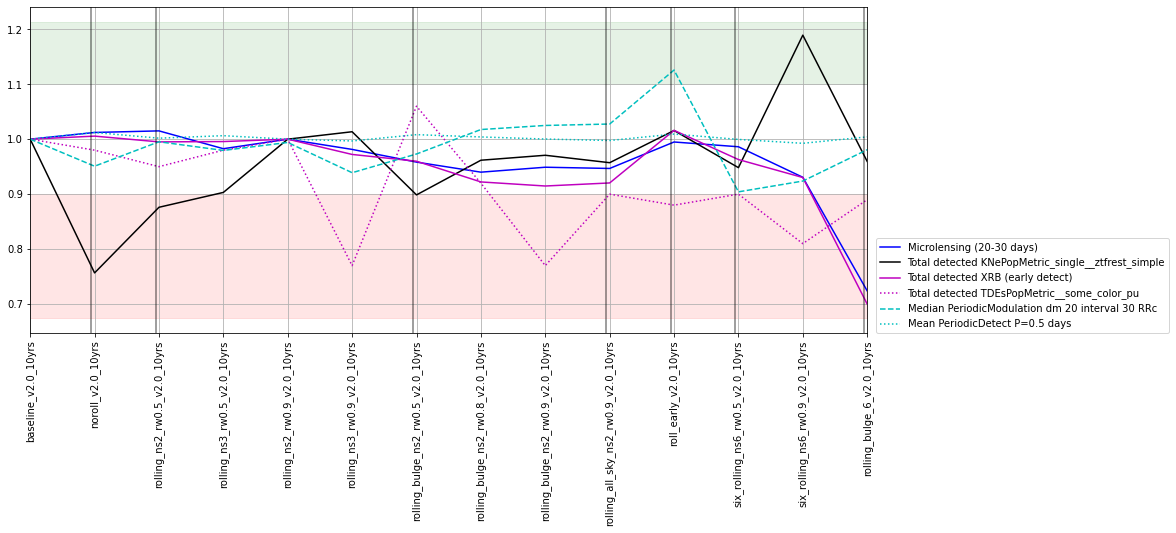

In [54]:
# TVS metrics
k_sets = [k for k in msets if k.startswith('TVS') and (k.endswith('short') or ('Tgaps' in k) or ('anomalies' in k)) ]

for k in k_sets:
    msub = metric_set.loc[k]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=msub['short_name'],
                                       metric_set=msub,
                                      color_range=0.5)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)

    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value', 
                                 shade_fraction=0.1)
    fig.set_figwidth(15)
    ylim = list(ax.get_ylim())
    ax.set_ylim(max(0.2, ylim[0]), min(2, ylim[1]))
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

These are some key metrics, in terms of rolling cadence metrics, as they strongly depend on cadence (as well as footprint, to varying extent). There are also a lot of metrics, and further feedback from the TVS community will help set improved priorities for the various metrics. In general, the last set 'TVS short' attempts to pull out the particular metrics which have been both indicated as most important in each set and also vary the most strongly across simulations. 

There are multiple KNe metrics -- a KNePopMetric run on all Bulla model KNe lightcurves, which is primarily used for DESC science evaluation; a KNePopMetric run on a single model lightcurve that generally matches GW170817 for TVS science (both of these can be evaluated with a wide set of 'detection' criteria); and a PrestoKNePopMetric which evaluates the likelihood of determining if a given KNe (that generally matches the GW170817 light curve) could be identified within a sea of other transients given the observations of the object. While PrestoKnePopMetric_Sum_scoreS represents the total number of Kne that are likely to meet the probability threshold of being identified as KNe, the TVS community has tenatively indicated that the Total detected KnePopMetric run on a single population and identified using the 'ztfrest_simple' criteria likely more accurately represent the overall preferred survey strategy. The PrestoKne metric is somewhat noisy among rolling cadence variations; there is some preference for rolling early, but as this is not reinforced by always preferring stronger rolling (although many weaker rolling cadence simulations show slightly poorer results), it is also potentially noise. The KNePopMetric_single_ shows more clearly that less strong rolling cadence performs worse (no rolling leads to a decrease of about 20% in the 'ztfrest_simple' and almost all other detection criteria), rolling cadence with 2 or 3 bands at 80-90% is fairly neutral, and a strong six-band rolling cadence results in an almost 20% increase in the ztfrest_simple and similar or better in most other detection criteria.  (it's worth noting the DESC preference is for the 'multi_detect' criteria which does *worse* for strong six-band rolling cadence by almost 20%). 

Other 'population based' TVS metrics include TDE detection and XRB detection, again with various criteria, and microlensing detection, with a variety of crossing times as well as summary metrics. The highest priority versions of these are in the 'TVS short' set.

The preferred detection criteria for TDE detection is not clear at the moment (Igor Andreoni is checking on it), but previous work indicated 'a color including u (some_color_pu)' was preferred. This is the most stringent discovery crtieria; generally this metric shows neutral results with rolling cadence, until a strong 3 or 6 band is introduced at which point the metric falls by ~20%, presumably due to the timescales and rarity of the events. It is notable that the quality of TDE lightcurves is also highest when the number of detections is lowest (which speaks to the rarity of the events - finding one is 'lucky', and sampling one well requires many observations within a short period of time .. most likely the detection overrides the sampling, as follow-up for rare but identifiable events can be done outside of the LSST).

The best metric for XRBs is likewise the 'early detect' criteria. The mean number of observations per event is fairly constant unless strong rolling within the bulge region (six bands in the bulge) is added, but this same strategy strongly decreases (by 30%) the total number of XRBs detectable. Most rolling cadence strategies are fairly neutral for XRBs; these objects are strongly concentrated toward the galactic plane, so strategies which add rolling cadence in the bulge show the strongest effects. These metrics argue against rolling cadence in the bulge, showing a decrease in detectable events on the order of 10%. 

Microlensing is simulated with a wide variety of crossing times, from 1-5 days up to >500 day timescales. At the longer timescales, we find very little variation in metric results across all simulations. At very short (<20 day) timescales, most simulations show big variations; in addition, microlensing TVS members have indicated these events are not their priority. The highest priority microlensing crossing times are 20-60 days and 200-500 days. Most of the variation we see is in the 20-30 day crossing time metrics. The microlensing events are also strongly concentrated toward the galactic plane, and we find the results of the metric primarily depend on whether or not rolling cadence is added in the bulge region. When it is, the number of microlensing events detected drops by ~5% and the fraction well sampled with high quality drops by ~10%. If a six-band rolling cadence is added, the decreases are even stronger, especially with a six-band bulge rolling cadence. These metrics slightly prefer a weaker or no rolling cadence, but not to any great extent. 

The remainder of the TVS metrics include estimates of how well periodic stars could be detected (periodic detect) or monitored (periodic star modulation). Detection of periodicity changes very little across rolling cadence, with the exception of fainter stars with periods close to 1 day; detecting periods in these stars is easier with no or weaker rolling cadence (by up to 50%) and is worse with a six-band rolling cadence by 30-50%. The metric that evalutes how well stars can be monitored for changes in their periodicity only uses the first two years of survey data (both due to design and due to metric run time); this metric shows little to no difference across rolling cadence strategies as a result. "roll early" does show an improvement, as this simulation adds rolling cadence earlier into the two year interval. The distribution of 'stars' in these metrics is uniform across the sky.

The final metrics in this area are somewhat  the 'TgapsPercent' metric, which looks at what fraction of revisits occur within 2-14 hours or around 1 day. In general, these metrics improve as the rolling cadence becomes stronger; the measurements in most bandpasses do not change significantly unless 3 or 6 band rolling cadence at strengths 80% or greater is used, and then the metric values by over 20% or over 40% (respectively). These metrics are not tied to a particular population of objects, just general exploration of the time domain. 


Across all TVS metrics, microlensing, XRB detection and TDE detection fall by 20-30% with a strong six-band rolling cadence.  KNe detection with TVS criteria rises by 20% with the same strong six-band rolling cadence, however falls by 20% when considering DESC detection criteria (which are aimed at different purposes). Overall, these metrics argue against a strong six-band rolling cadence anywhere on the sky and also in the bulge region. 

XRB detection and microlensing also fall by about 10% with the addition of rolling cadence in the bulge. 
No TVS metrics show a large improvement with the addition of rolling cadence in the bulge specifically (presumably due to the timescales of galactic-oriented populations here, but see the galaactic plane footprint metrics below, which attempt to capture a variety of timescales for phenomena that may occur within the bulge region). 

Most of these metrics are fairly neutral (outside the bulge region) across no rolling or 2 band rolling cadence, with the exception of the KNe detection metric (TVS version). This metric falls by >20% without any rolling cadence, and 50% strength rolling cadences result in a negative impact on the order of 10%. 
(worth noting that we see further improvements in the KNe metric when 'suppress revisits in the same night' (suppress repeats famil) is activated; it's likely worth evaluating the impact of no rolling + suppress revisits, given that other metrics may do slightly better with no rolling cadence). 

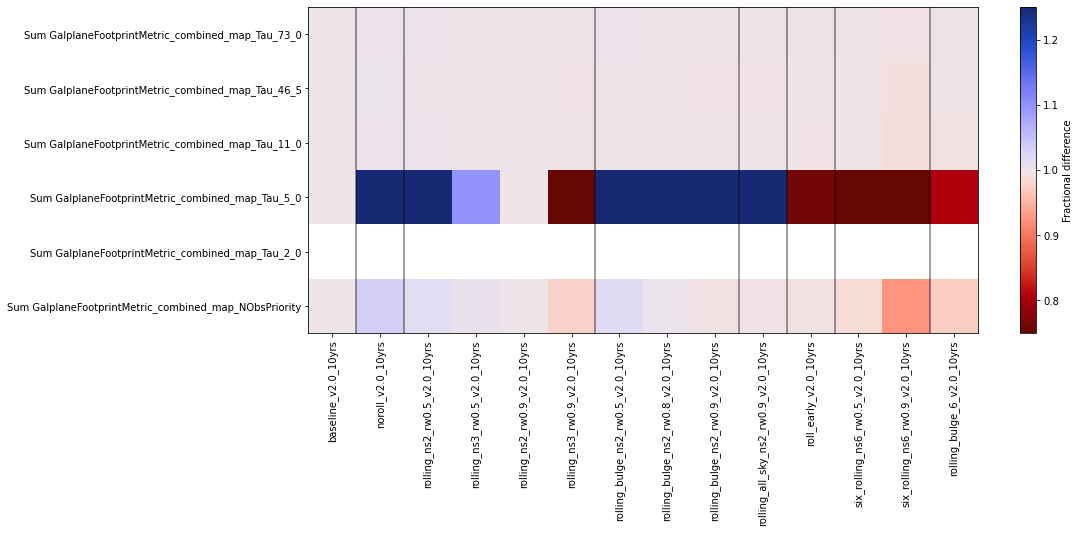

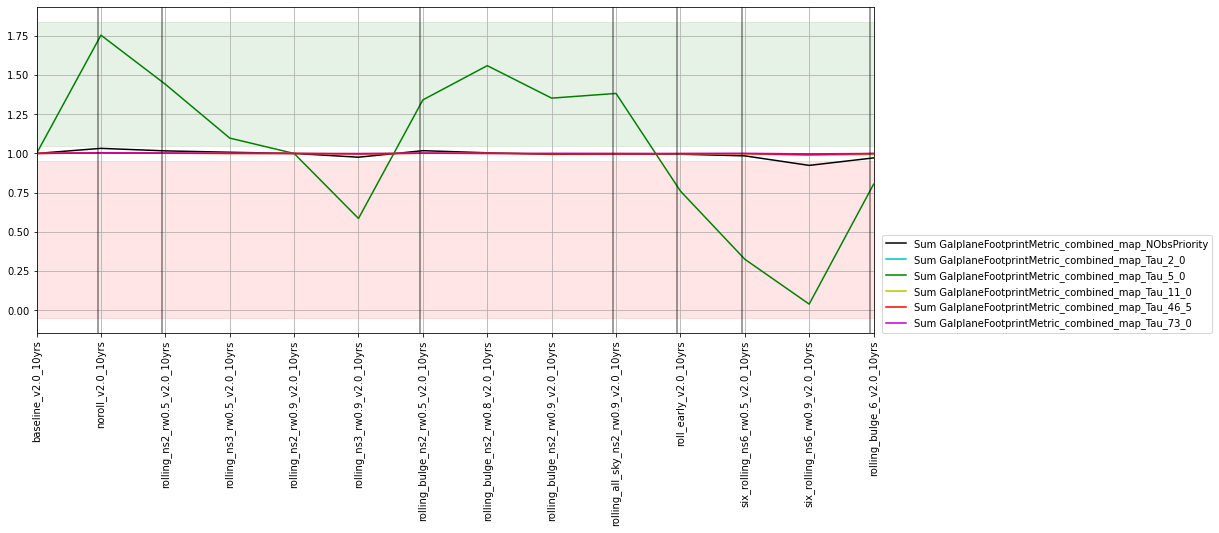

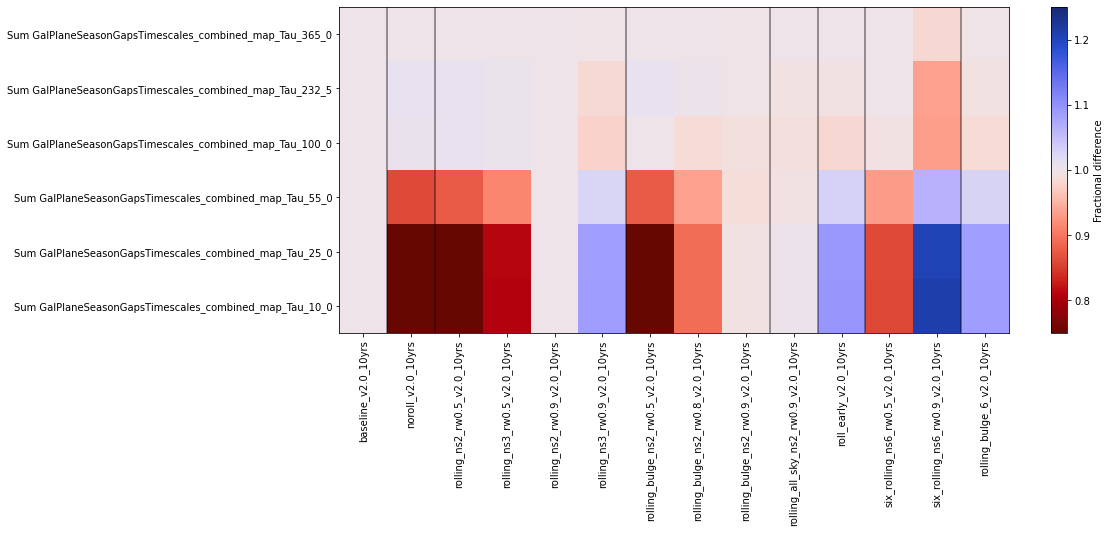

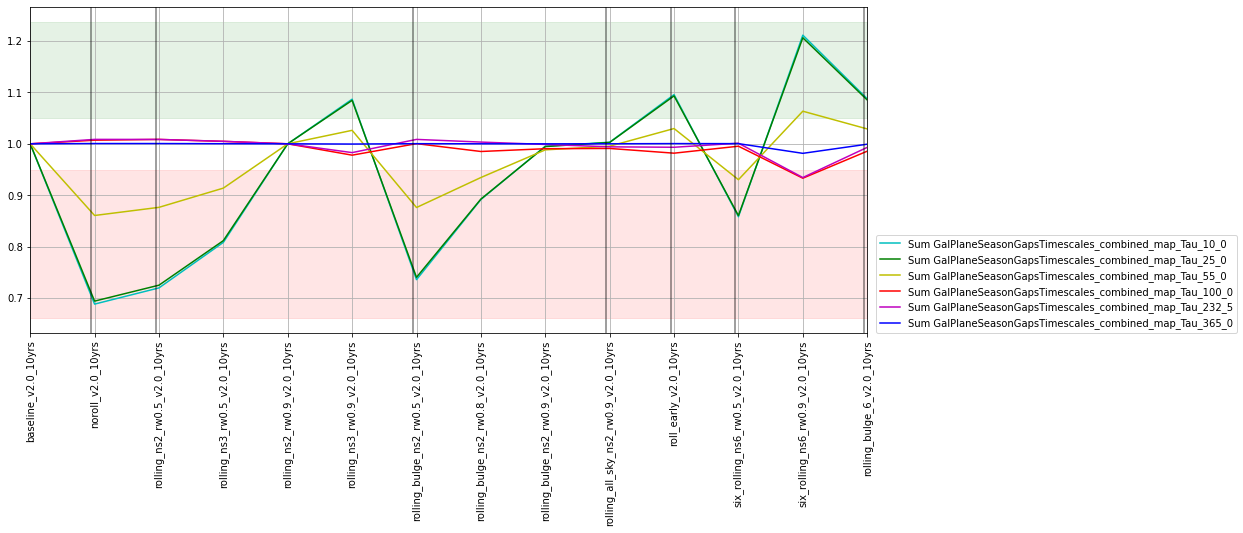

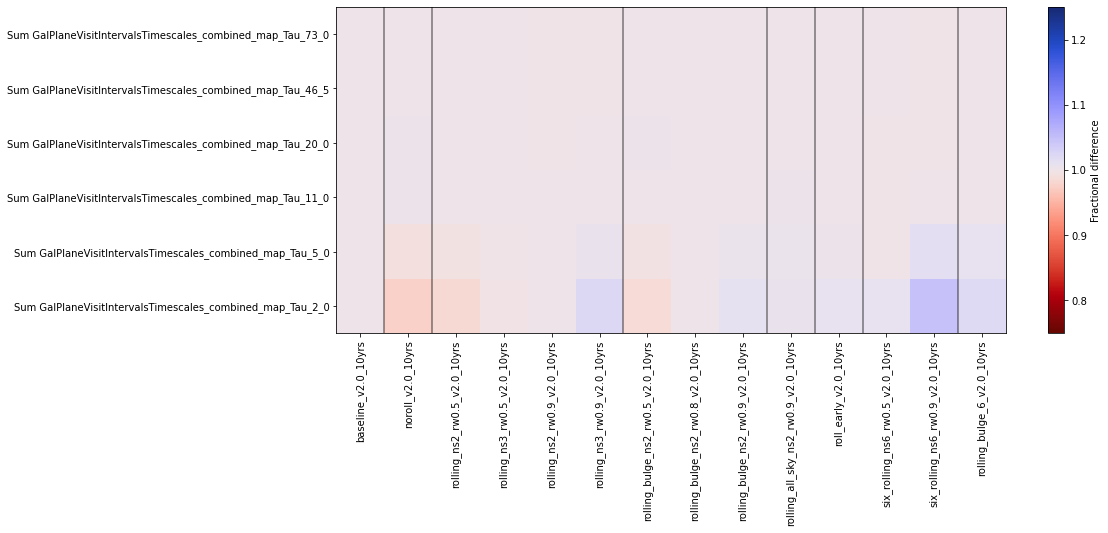

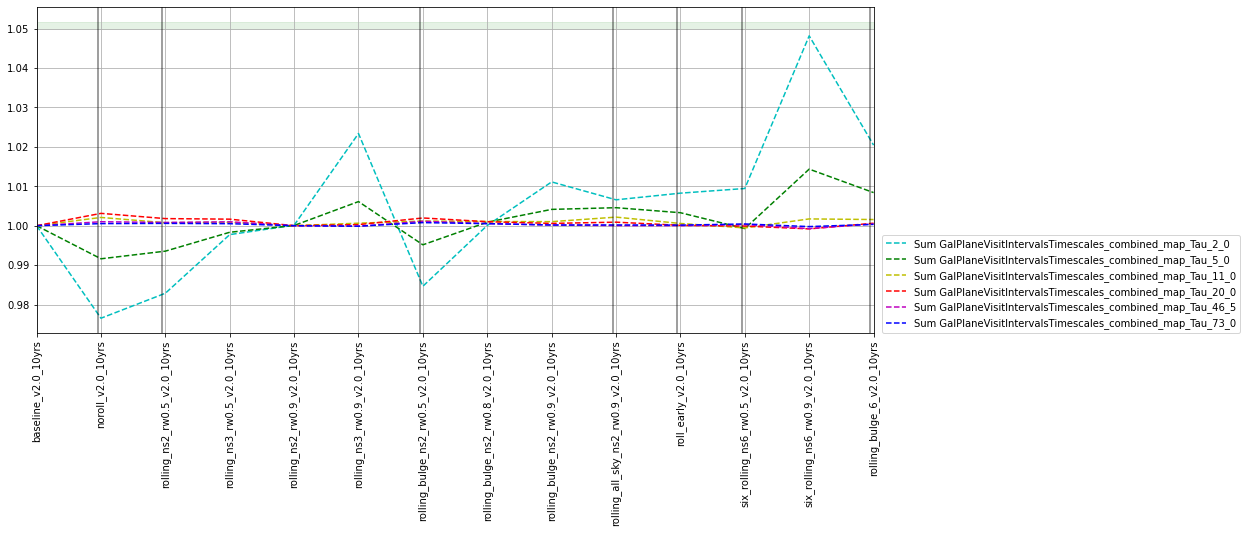

In [55]:
# GP footprint metrics
k_sets = [k for k in msets if k.startswith('GP') and 'filter' not in k]

for k in k_sets:
    msub = metric_set.loc[k]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=msub['short_name'],
                                       metric_set=msub,
                                      color_range=0.5)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)

    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    #ax.set_ylim(0.5, 1.5)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

These metrics represent an attempt to encapsulate general thoughts about preferred cadence in the galactic plane, specifically weighted by the galactic plane priority map, and represent them with metrics. The 'FootprintMetric' reflects how much (and how heavily weighted in the priority map) area that acquire at least X number of visits (X depends on Tau -- as Tau decreases, the number of visits increases; Tau=5 corresponds to 791 visits per pointing). As rolling decreases, it is clear that area within the dusty plane and bulge diamond receive slightly more visits per pointing and as rolling increases, the visits in this area start to fall below the threshold of 791 per pointing. It's not immediately obvious why this is the case, given that the overall number of visits per pointing is fairly constant, but area can quickly fall above or below thresholds around 800 visits per pointing. 

The SeasonGaps and VisitIntervals metrics are more meaningful in this context. The SeasonGaps show whether or not the seasons become slightly longer or shorter (depending on Tau). We see here that as rolling cadence strength increases, the length of (at least some) seasons becomes longer; in other metrics, we see that the median season length is unchanged, so this is likely the effect of rolling cadence slightly increasing the season length in active years. The VisitIntervals metric demonstrates whether the sampling of visits on timescales from 2 to 73 days changes significantly; interestingly, these values do not change much across different rolling cadence options. I suspect this is because the sampling in rolling cadence primarily focuses on the Tau=2 timescale; variations on timescales below 2 days do not affect the metric results. Most of the impact of rolling cadence is focused on moving revisits from around 4 nights down to around 2 nights, but there is a distribution of revisit times that likely softens the change in metric results. We do see an improvement of metric values for VisitIntervals at Tau=2, but it is only on the order of +/-2%.

Generally these metrics do not influence the decisions around rolling cadence outside of the bulge significantly.

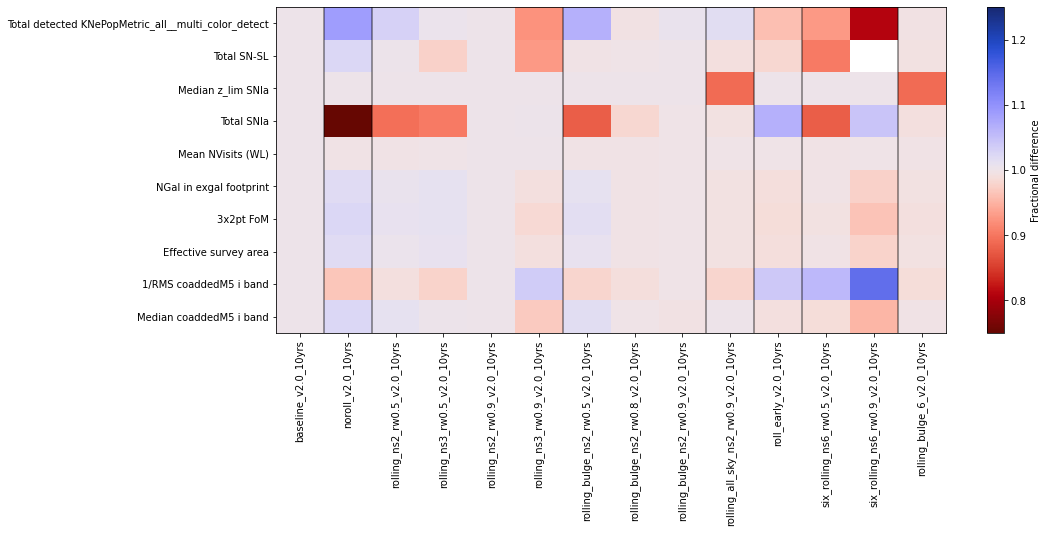

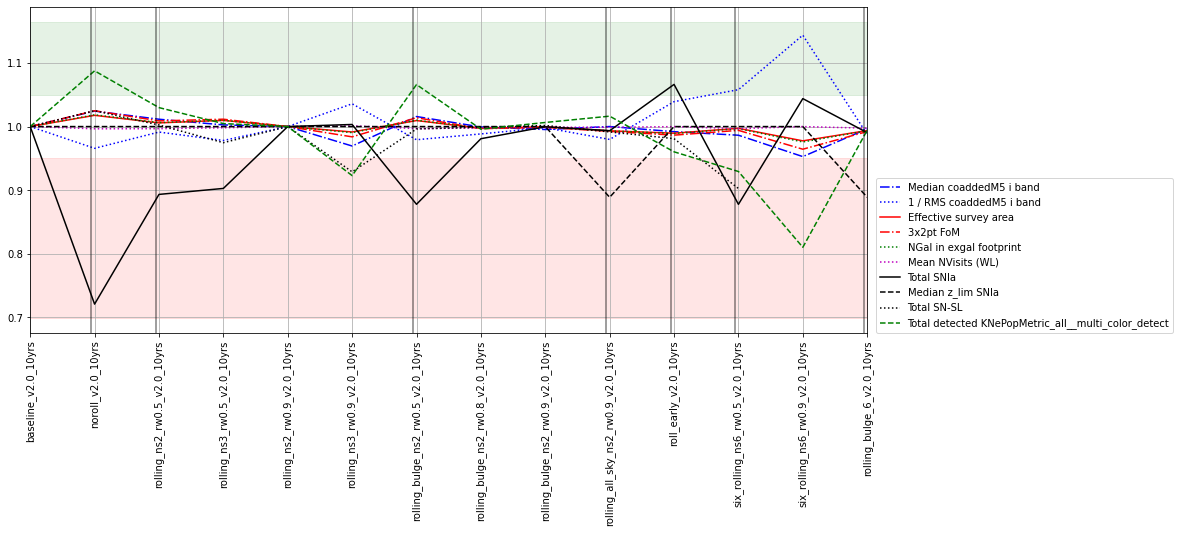

In [56]:
# DESC metrics
k_sets = [k for k in msets if k.startswith('DESC') and not k.endswith('DDF')]

for k in k_sets:
    msub = metric_set.loc[k]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=msub['short_name'],
                                       metric_set=msub,
                                      color_range=0.5)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)

    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    #ax.set_ylim(0.5, 1.5)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

The majority of the DESC WFD metrics are related to static science, and as such, do not show strong changes with rolling cadence. The exceptions are the SN, SN-SL, and KNe (DESC version) metrics. The SN metric is still in the process of confirmation and needs to be rerun; the values in this plot should not be considered reliable (this note will be removed when this is fixed). 

In general, there is a slight preference for no rolling cadence, based on the KNe metric in this configuration, where KNe are desired to be detected but identification will be based on GW confirmation (rather than requiring identification via color + rise/fall in magnitude) and strong lensed SN (which are very rare and thus require observing a lot of sky, but would be confirmed by knowledge of the presence of a strong lens and thus do not require identification but only observation of the event). The exception is likely to be SNeIa, but we need to wait on confirmation of this metric.

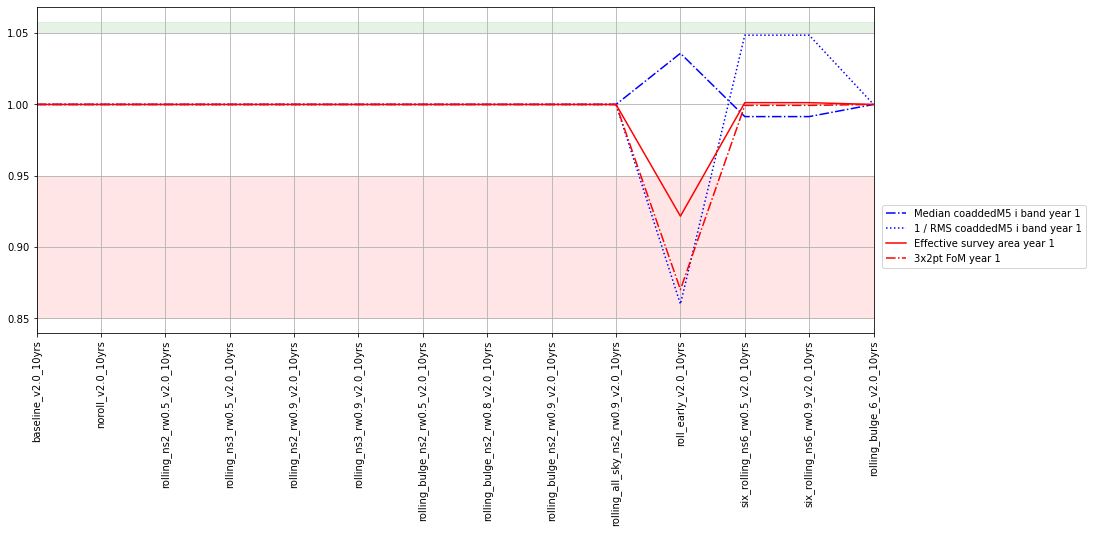

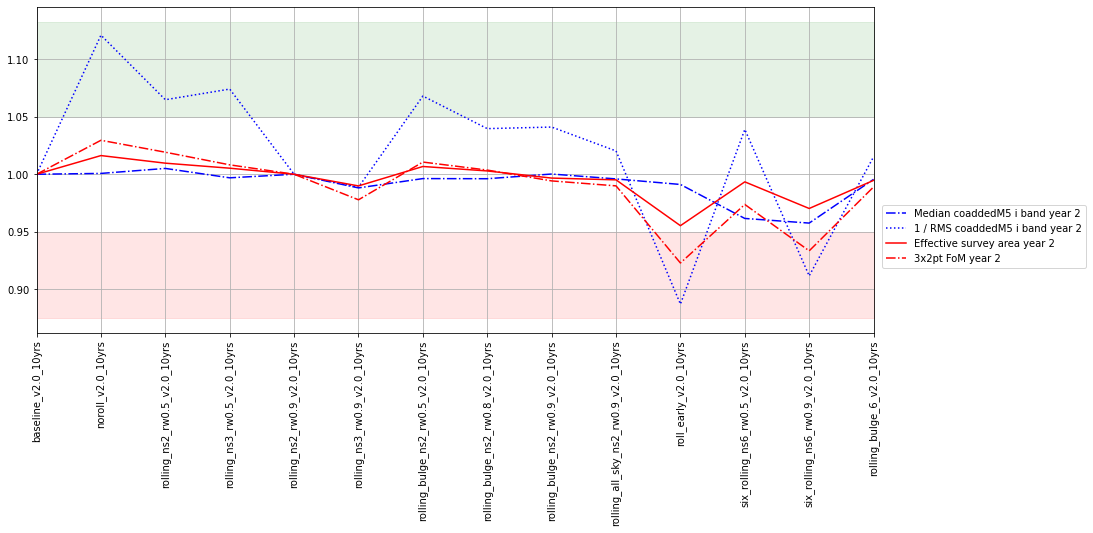

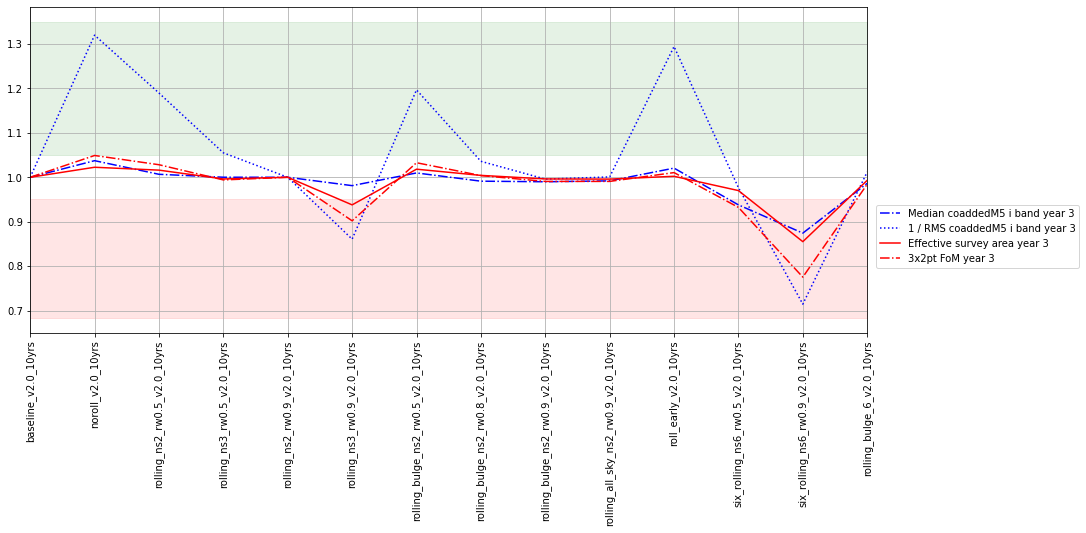

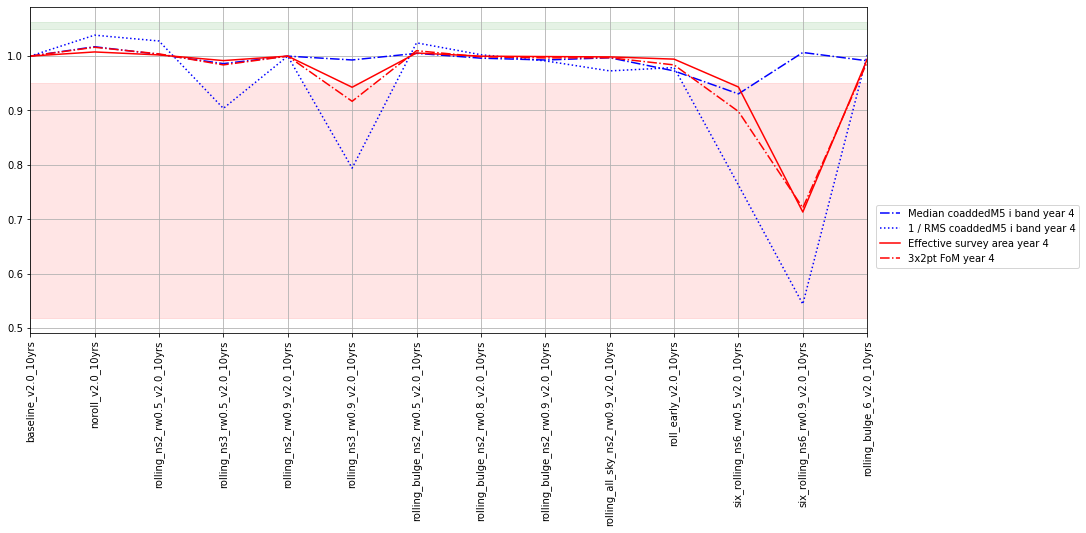

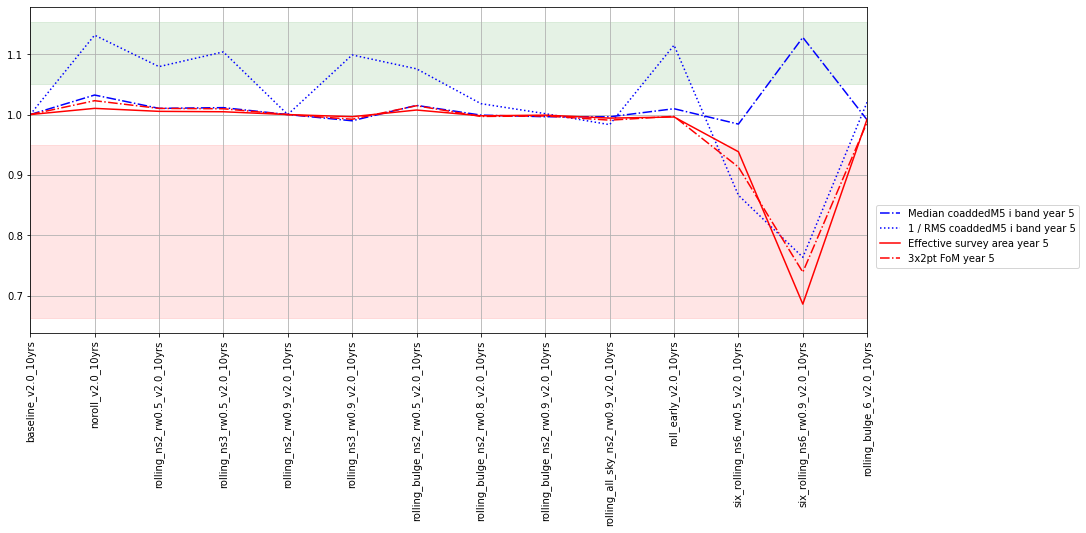

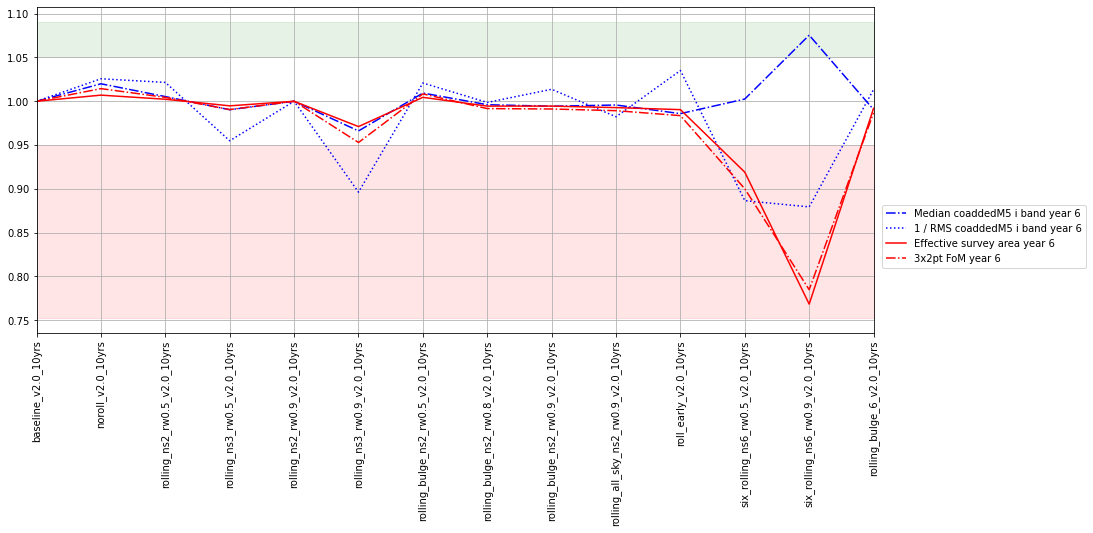

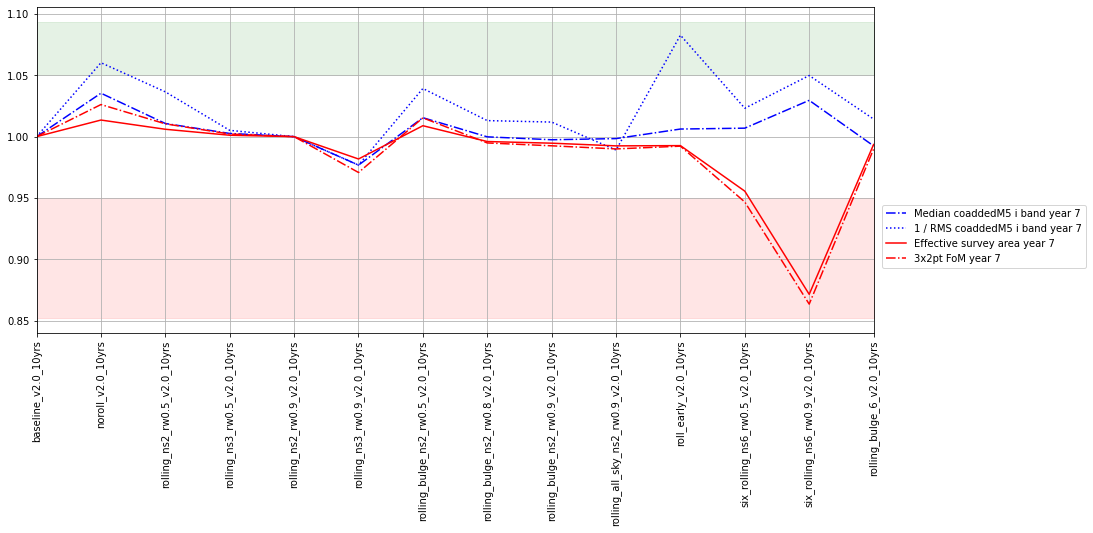

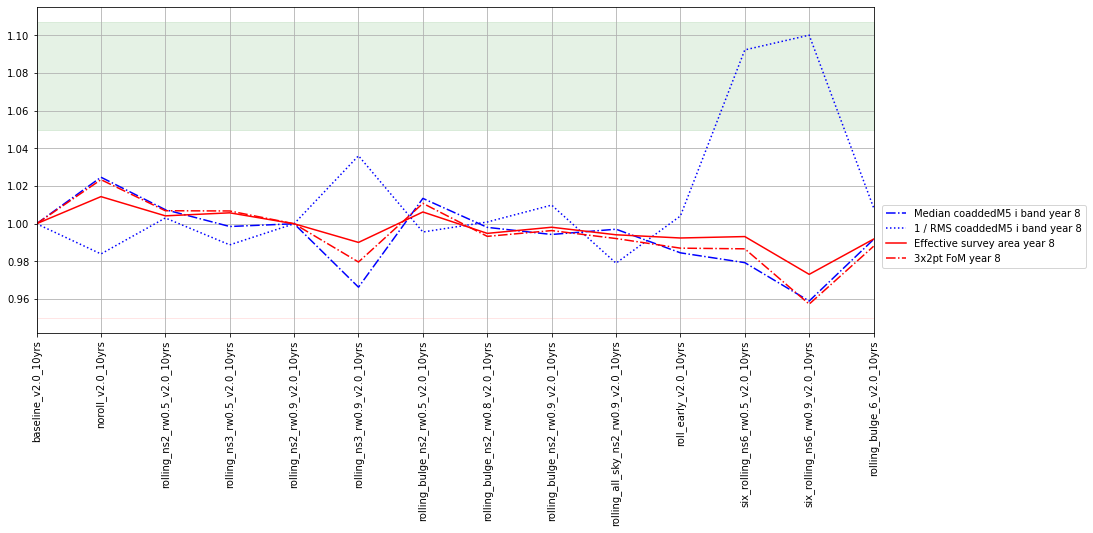

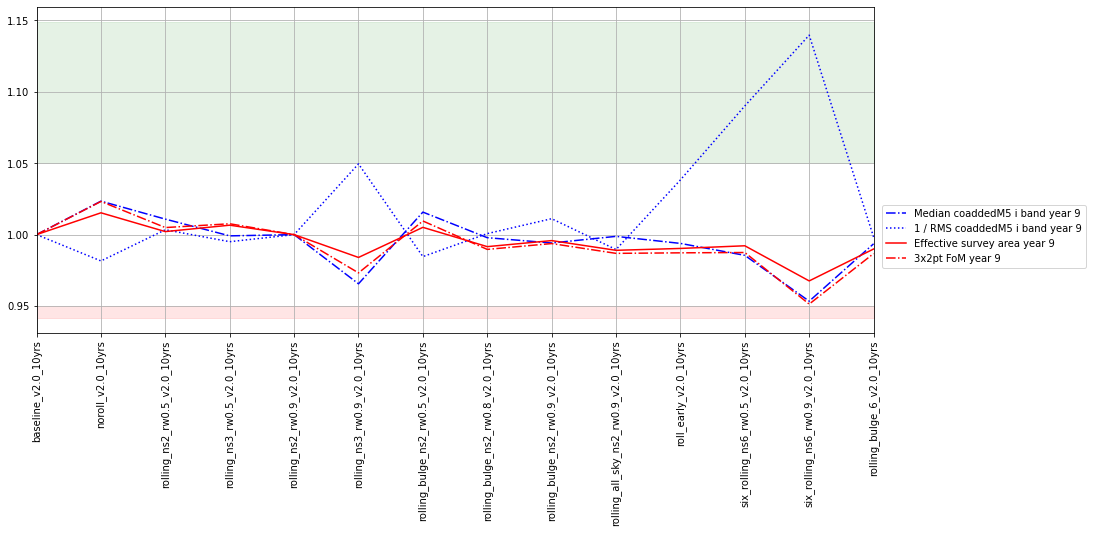

In [57]:
# Evaluate non-uniformity 

msub = metric_set.loc['DESC WFD'].query('metric.str.contains("year")')
for year in np.arange(1, 10, 1):
    tag = 'year %d' % year
    metrics = [f"{m.split('year')[0]}{tag} HealpixSlicer" for m in msub['metric']]
    short_names = [f"{m} {tag}" for m in msub['short_name']]
    invert = msub['invert']
    mag = msub['mag']
    style = msub['style']
    if year == 1:
        mset = maf.create_metric_set_df(f'DESC WFD {tag}',  metrics, short_names, 
                                        style=style, invert=invert, mag=mag)
    else:
        mset = pd.concat([mset, maf.create_metric_set_df(f'DESC WFD {tag}',  metrics, short_names,
                                                        style=style, invert=invert, mag=mag)])
baseline_run = 'baseline_v2.0_10yrs'
these_runs = families.explode('run').loc['rolling', 'run'].values
if baseline_run not in these_runs:
    these_runs = np.concatenate([[baseline_run], these_runs])
for yr in np.arange(1, 10, 1):
    k = 'DESC WFD year %d' % yr
    fig, ax = maf.plot_run_metric(  # pylint: disable=invalid-name
            summaries.loc[these_runs, mset.loc[k]['metric']], 
            metric_set=mset.loc[k],
            baseline_run=baseline_run,
            vertical_quantity="value",
            horizontal_quantity="run",
            metric_label_map=mset.loc[k]['short_name']
        )
    lgd = plt.legend(loc=(1.01, 0.2), fancybox=True, numpoints=1, fontsize='medium')
    figwidth = min(10, len(these_runs))
    figwidth = max(figwidth, 15)
    fig.set_figwidth(figwidth)

Looking at DESC WFD static science metrics and the uniformity of the survey year/year with rolling cadence: 
The first year shows no changes relative to baseline, except for the 'roll early' version, which isn't that surprising -- the rolling cadence doesn't start in the first year, except for the "roll early" simulation. When rolling cadence starts early, the first year shows the effects of rolling cadence kicking in without a 'background' of 1.5 years of observing without the rolling cadence to "soften" the variations of depth. 

In the second year, rolling cadence starts .. for most versions of rolling, the metrics don't change much. Rollearly shows the effects of rolling cadence continuing on top of a more non-uniform background, and for six-band rolling cadence variations, the metrics show more variability. 

The 'no roll' run shows the effect of no rolling cadence, in a lower variation in coadded i-band depth over the sky, but this effect is the strongest in year 3, while it is less strong in any other year, most likely due to the smaller impact in additional visits on depth in later years (after more visits).  This is also seem in the rolling cadence variations with lighter 'weight' on rolling (rw=0.5 simulations). The overall amount of effective survey area is very similar year over year, for any rolling cadence variation. 

Further evaluation of uniformity and uniformity requirements would be useful. 

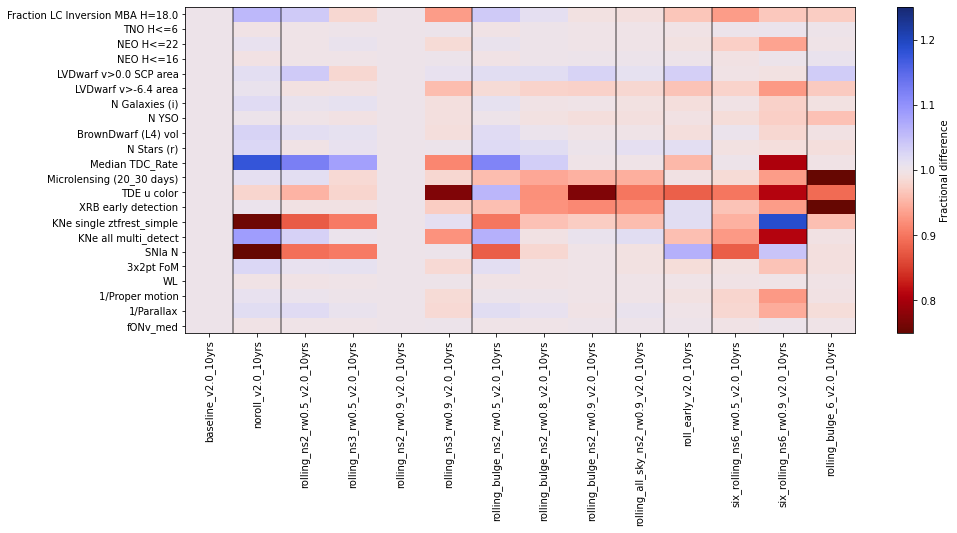

In [58]:
## high level across all 

k_sets = ['SCOC']

for k in k_sets:
    msub = metric_set.loc[k]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=msub['short_name'],
                                       metric_set=msub,
                                      color_range=0.5)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)


49


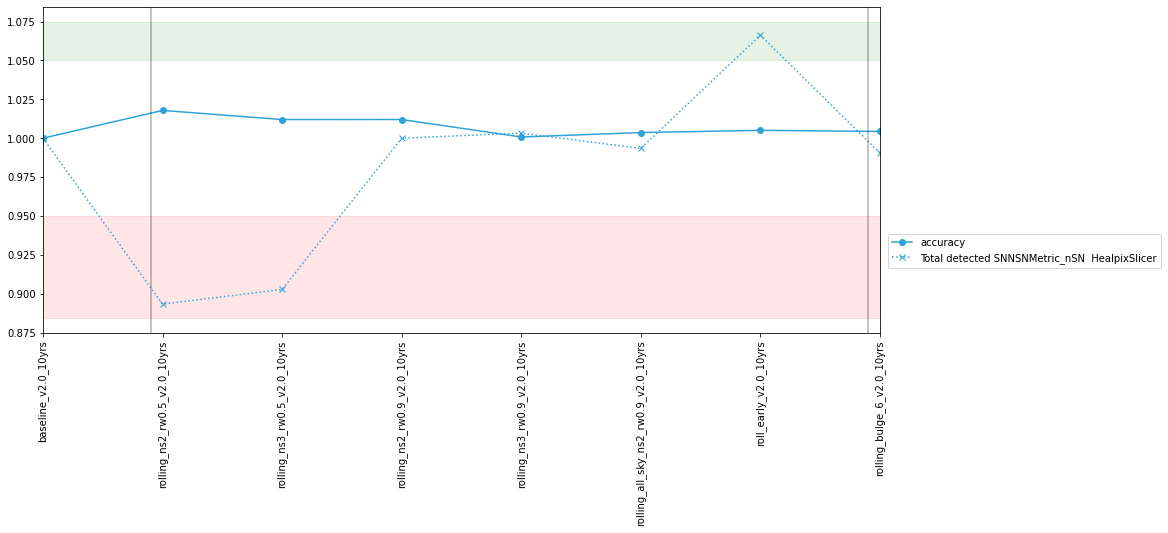

In [27]:
# SN classification efficiency from Fabio Ragosta & Federica Bianco - slack message May 29

sn_summary = pd.read_csv('SN_classification_efficiency_TVS.csv', index_col=1).drop('Unnamed: 0', axis=1)
print(len(sn_summary))
runs = sn_summary.index.to_list()
def conform_names(r):
    return r+"_10yrs"
sn_summary.rename(mapper=conform_names, inplace=True)

family = ['rolling']
baseline_run = 'baseline_v2.0_10yrs'
these_runs = families.explode('run').loc[family, 'run'].values
if baseline_run not in these_runs:
    these_runs = np.concatenate([[baseline_run], these_runs])

# Not all of the runs are in the sn_summary
these_runs_subset = [r for r in these_runs if r in sn_summary.index]

    
fig, ax = maf.plot_run_metric(  # pylint: disable=invalid-name
        sn_summary.loc[these_runs_subset, ['accuracy']], 
        vertical_quantity="value",
        horizontal_quantity="run",
        linestyles=['-'],
    )
m2 = metric_set.loc['DESC WFD'].query('metric == "Total detected SNNSNMetric_nSN  HealpixSlicer"')
fig, ax = maf.plot_run_metric(  # pylint: disable=invalid-name
        summaries.loc[these_runs_subset, m2['metric']], 
        baseline_run=baseline_run,
        vertical_quantity="value",
        horizontal_quantity="run",
        linestyles = [':'],
        markers= ['x'],
        ax=ax
    )
lgd = plt.legend(loc=(1.01, 0.2), fancybox=True, numpoints=1, fontsize='medium')
figwidth = min(10, len(these_runs))
figwidth = max(figwidth, 15)
fig.set_figwidth(figwidth)

plot_lines = [1, 7, 13, 19, 25, 33]
for l in plot_lines:
    ax.axvline(l - 0.1, color='k', alpha=0.3)

Note that 'accuracy' is an attempt to estimate how *well* SN could be classified *if* they were detected. The detection criteria (or overall number of SN detected) is not reflected in the accuracy. This shows that, once counted as 'detected', the likelihood of classification is not a strong function of rolling cadence. 

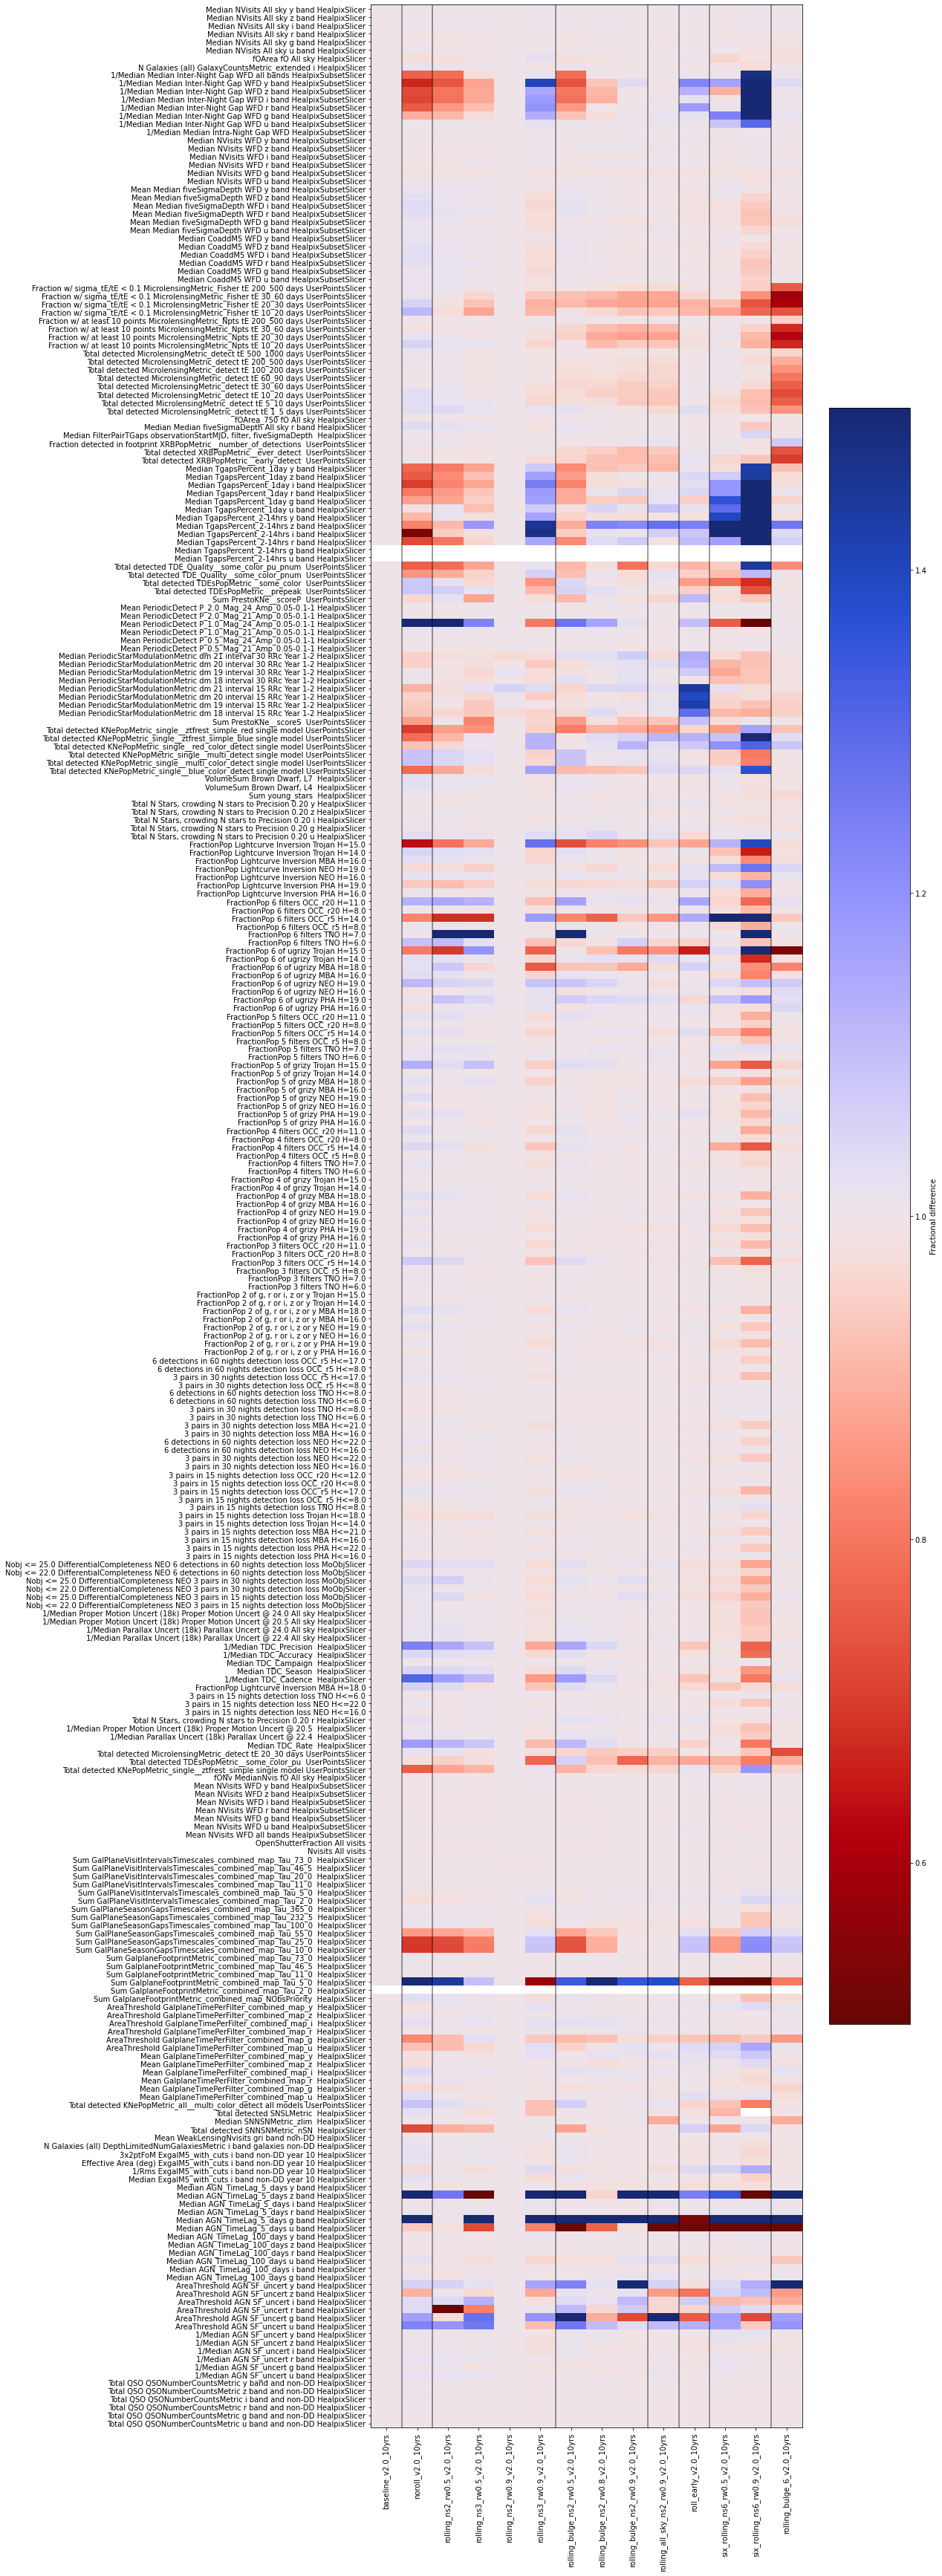

In [28]:
# We can plot them all together, but need to remove duplicates
non_dd = [m for m in msets if 'DD' not in m]
msub = metric_set.loc[non_dd].reset_index(drop=True).drop('style', axis=1).drop('short_name', axis=1)
msub = msub.drop_duplicates().set_index('metric', drop=False, verify_integrity=True)
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=1)
fig.set_figwidth(13)
fig.set_figheight(60)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

Some overall thoughts:

* Against rolling: <br>
strong lensing related metrics improve with no rolling cadence by as much as 20% <br>
DESC-version KNe detections improve with no rolling cadence by about 8% 

* For rolling: <br>
TVS-version KNe identifications decrease with rolling cadence by a bit more than 20% <br>
DESC SN metrics *may* show a large decrease with no rolling cadence (>20%)

* The above trends for and against rolling hold consistent for 50% rolling cadence in 2 or 3 bands. 

* No six-band rolling: <br>
Only TVS-version KNe identification metrics show any preference for a 6-band rolling cadence, at 20%. <br> 
Other metrics (DESC version KNe detection metrics, SSO metrics, microlensing, XRB detection, TDE detection, strong lensing time delays) fall by 10% (or often more, 20-30%+) with a 90% strength 6-band rolling cadence. 

* Not all-sky rolling: <br>
No metrics show a preference for rolling cadence in the galactic plane - microlensing and XRB detection show 10% decreases when rolling cadence in the bulge region is added.
It may make sense to include rolling in the bulge anyway, as there may be populations that are not reflected in our current metrics. 




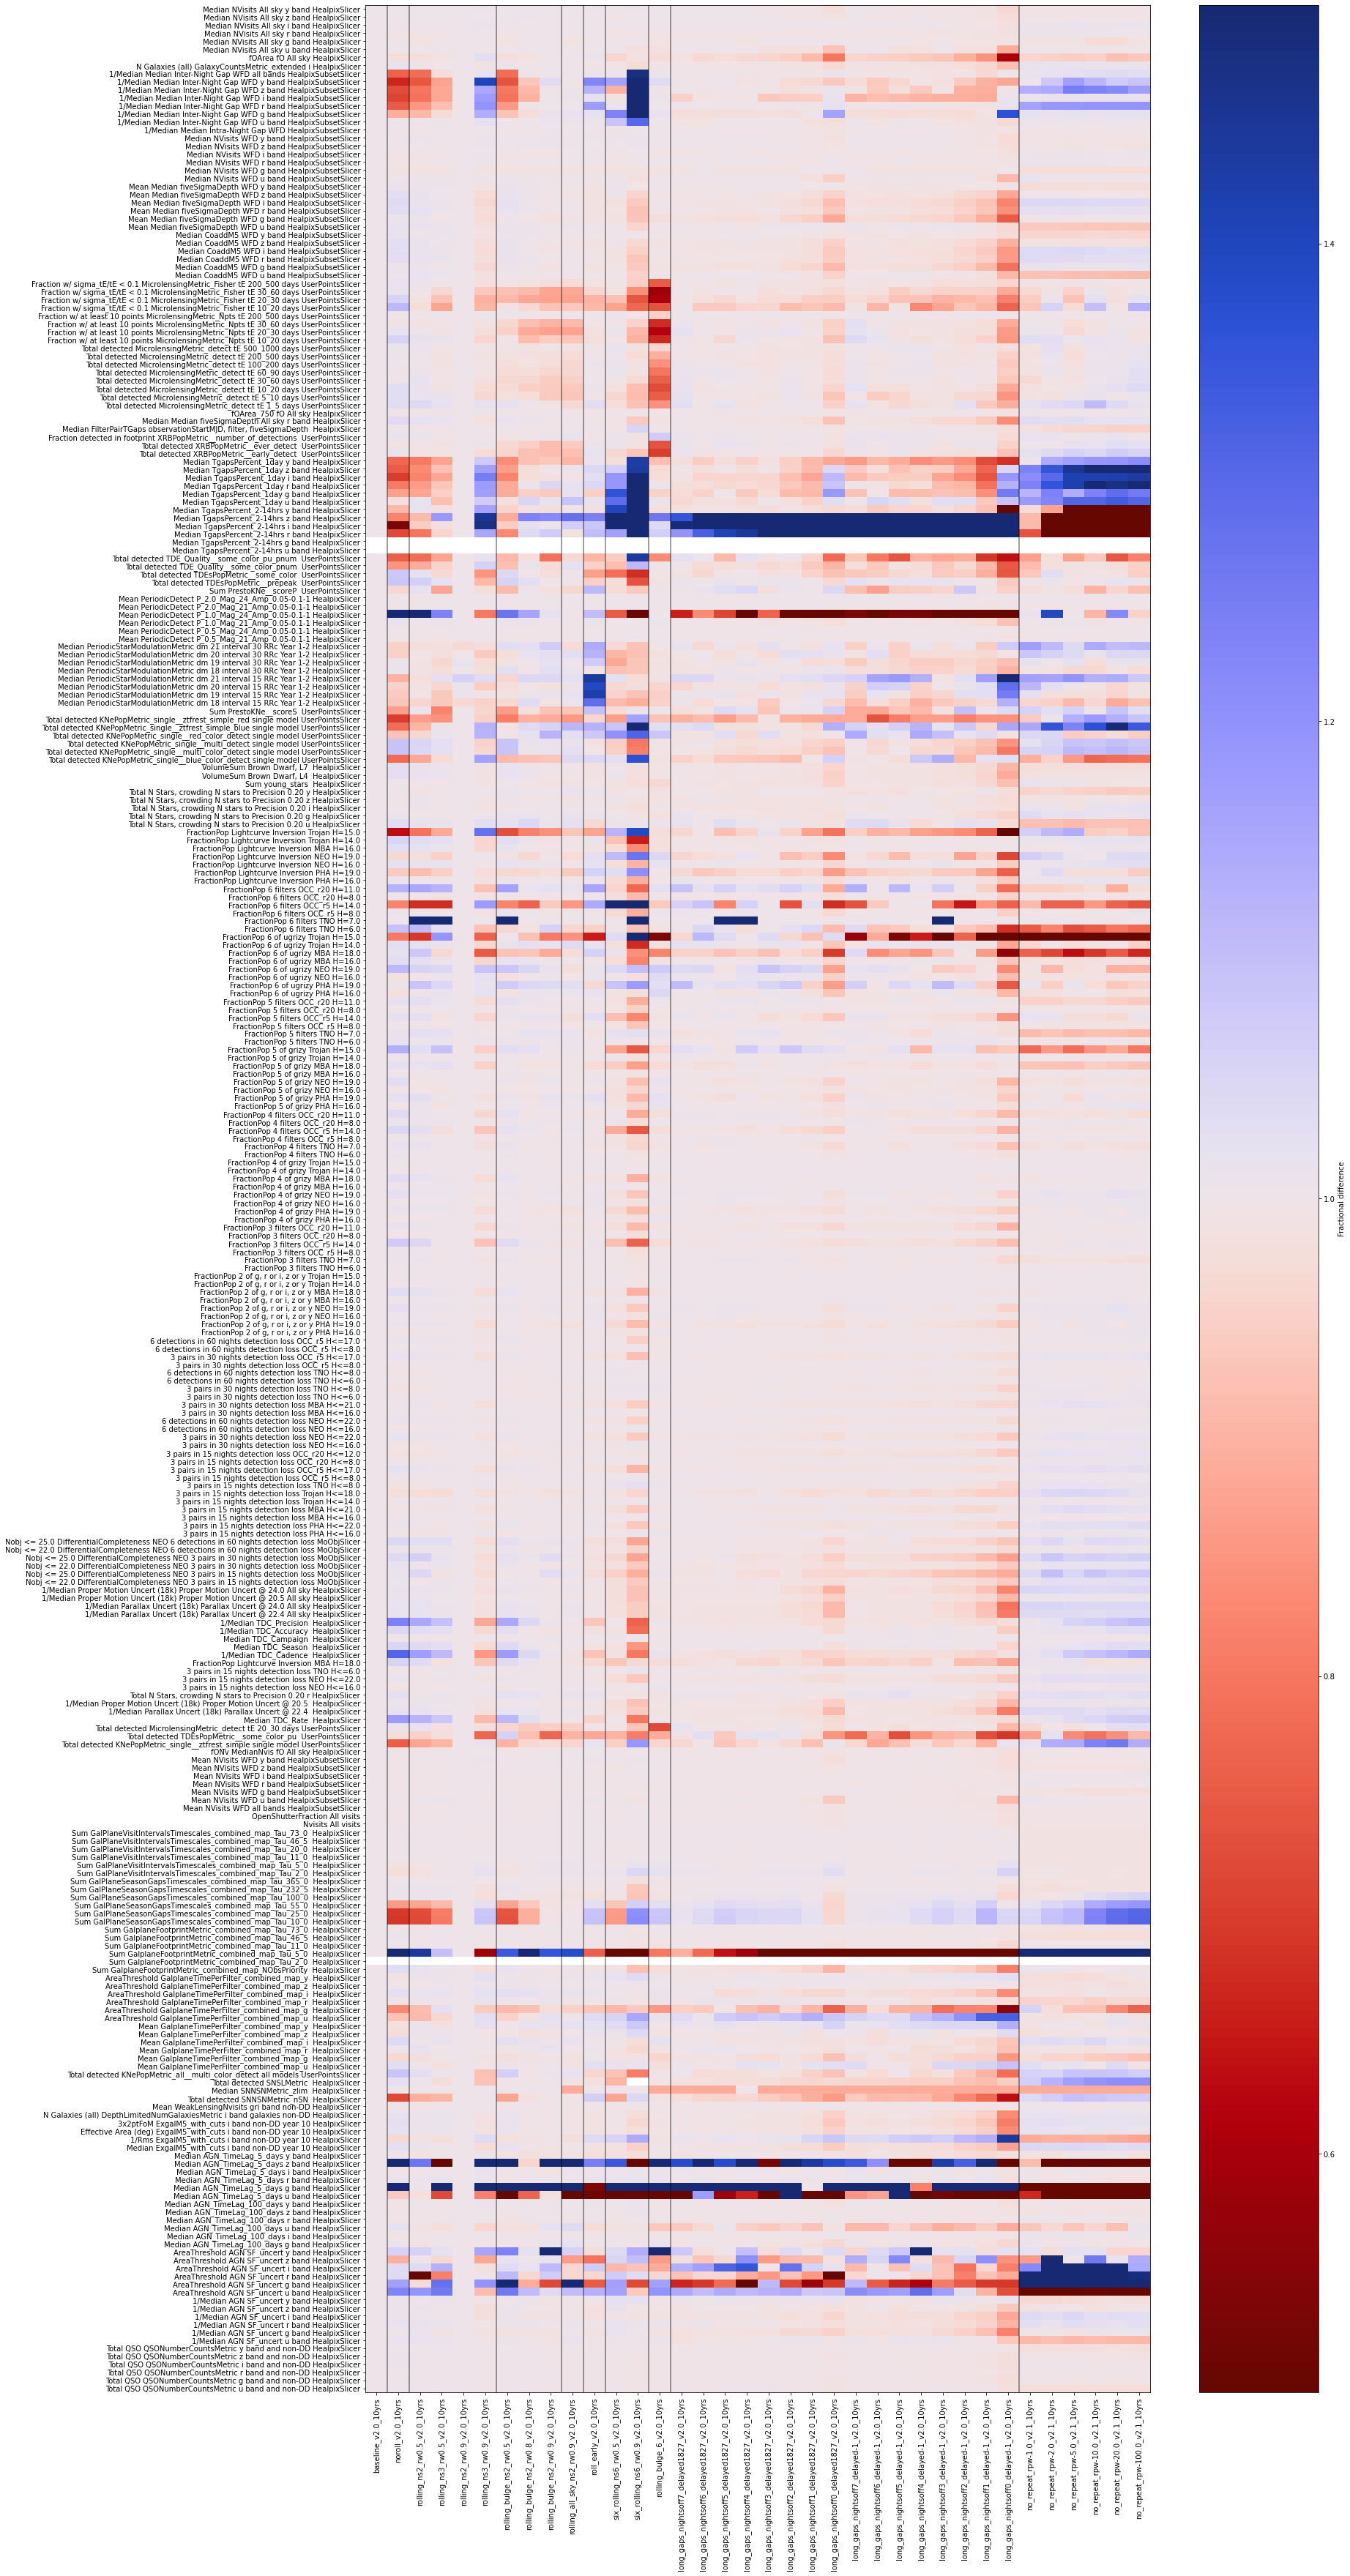

In [44]:
# There are some potential overlaps between rolling cadence and third visits or suppress revisits - so 
# add them all together here 

fams = ['rolling', 'triplets', 'suppress repeats']
baseline_run = 'baseline_v2.0_10yrs'
more_runs = np.concatenate([[baseline_run], families.explode('run').loc[fams, 'run']])
more_runs = [r for r in more_runs if not r.startswith('presto')]
lines = np.array([1, 2, 6, 9, 10, 11, 13, 14, (14+16)])

# We can plot them all together, but need to remove duplicates
non_dd = [m for m in msets if 'DD' not in m]
msub = metric_set.loc[non_dd].reset_index(drop=True).drop('style', axis=1).drop('short_name', axis=1)
msub = msub.drop_duplicates().set_index('metric', drop=False, verify_integrity=True)
fig, ax = maf.plot_run_metric_mesh(summaries.loc[more_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=1)
fig.set_figwidth(24)
fig.set_figheight(60)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)